In [ ]:
# Install PyTorch Geometric and dependencies (make sure torch is already installed)
!pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f https://data.pyg.org/whl/torch-2.0.0+cpu.html
!pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f https://data.pyg.org/whl/torch-2.0.0+cu118.html


Looking in links: https://data.pyg.org/whl/torch-2.0.0+cpu.html
Looking in links: https://data.pyg.org/whl/torch-2.0.0+cu118.html


In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GCNConv, SAGEConv
from torch_geometric.loader import DataLoader

# Load Cora dataset
dataset = Planetoid(root='data/Cora', name='Cora')
data = dataset[0].to('cuda' if torch.cuda.is_available() else 'cpu')
device = data.x.device

# Define GCNMean model
class GCNMean(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)
        self.dropout = 0.5

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        return x

# Instantiate and train model
model = GCNMean(dataset.num_node_features, 64, dataset.num_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

for epoch in range(200):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = F.cross_entropy(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()

    # Optional: print accuracy every 20 epochs
    if epoch % 20 == 0:
        model.eval()
        pred = out.argmax(dim=1)
        acc = (pred[data.val_mask] == data.y[data.val_mask]).float().mean().item()
        print(f"Epoch {epoch:03d} - Val Acc: {acc:.4f}")

# Save the victim model
import os
os.makedirs("checkpoints", exist_ok=True)

# Save the victim model
torch.save(model.state_dict(), "checkpoints/victim_Cora_GCNMean.pth")
print("✅ Saved victim GCNMean for Cora.")


/usr/local/lib/python3.11/dist-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: /usr/local/lib/python3.11/dist-packages/torch_scatter/_version_cpu.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/usr/local/lib/python3.11/dist-packages/torch_geometric/typing.py:97: UserWarning: An issue occurred while importing 'torch-cluster'. Disabling its usage. Stacktrace: /usr/local/lib/python3.11/dist-packages/torch_cluster/_version_cpu.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  warnings.warn(f"An issue occurred while importing 'torch-cluster'. "
/usr/local/lib/python3.11/dist-packages/torch_geometric/typing.py:113: UserWarning: An issue occurred while importing 'torch-spline-conv'. Disabling its usage. Stacktrace: /usr/local/lib/python3.11/dist-packages/torch_spline_conv/_version_cpu.so: undefined symbol: _ZN3c1017RegisterOp

Epoch 000 - Val Acc: 0.2080
Epoch 020 - Val Acc: 0.7700
Epoch 040 - Val Acc: 0.7380
Epoch 060 - Val Acc: 0.7640
Epoch 080 - Val Acc: 0.7640
Epoch 100 - Val Acc: 0.7640
Epoch 120 - Val Acc: 0.7760
Epoch 140 - Val Acc: 0.7740
Epoch 160 - Val Acc: 0.7660
Epoch 180 - Val Acc: 0.7680
✅ Saved victim GCNMean for Cora.


In [ ]:
from torch_geometric.loader import DataLoader

def extract_fingerprint(model, data=None):
    model.eval()
    if data is None:
        data = dataset[0].to(device)
    with torch.no_grad():
        x = F.relu(model.conv1(data.x, data.edge_index))
        x = F.dropout(x, p=model.dropout, training=False)
        x = model.conv2(x, data.edge_index)
        fingerprint = x.mean(dim=0).unsqueeze(0)  # global mean pooling
    return fingerprint



In [ ]:
fp_victim = extract_fingerprint(model)
print("✅ Extracted fingerprint from victim GCNMean")


✅ Extracted fingerprint from victim GCNMean


In [ ]:
from tqdm import tqdm
import os

def generate_fingerprint_variants(model_class, variant_name, dataset_name, num_variants=200, base_dir="variants"):
    os.makedirs(f"{base_dir}/{dataset_name}_{variant_name}/positive", exist_ok=True)
    os.makedirs(f"{base_dir}/{dataset_name}_{variant_name}/negative", exist_ok=True)

    # Positive variants (model with same architecture and dataset)
    print("Generating positive variants…")
    for i in tqdm(range(num_variants), desc="positive"):
        m = model_class(dataset.num_node_features, 64, dataset.num_classes).to(device)
        train(m)  # same training loop
        torch.save(m.state_dict(), f"{base_dir}/{dataset_name}_{variant_name}/positive/positive_{i:03d}.pth")

    # Negative variants (model with same architecture but on shuffled labels)
    print("Generating negative variants…")
    for i in tqdm(range(num_variants), desc="negative"):
        m = model_class(dataset.num_node_features, 64, dataset.num_classes).to(device)
        train(m, shuffle_labels=True)  # define shuffle inside train()
        torch.save(m.state_dict(), f"{base_dir}/{dataset_name}_{variant_name}/negative/negative_{i:03d}.pth")

    print(f"✅ Saved {2*num_variants} variants to {base_dir}/{dataset_name}_{variant_name}/")


In [ ]:
def train(model, epochs=200, shuffle_labels=False):
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

    # If negative variant, shuffle the labels
    y_train = data.y.clone()
    if shuffle_labels:
        y_train = y_train[torch.randperm(y_train.size(0))]

    for epoch in range(epochs):
        optimizer.zero_grad()
        out = model(data.x, data.edge_index)
        loss = F.cross_entropy(out[data.train_mask], y_train[data.train_mask])
        loss.backward()
        optimizer.step()



In [ ]:
generate_fingerprint_variants(
    model_class=GCNMean,
    variant_name="GCNMean",
    dataset_name="Cora",
    num_variants=200,
    base_dir="variants"
)


Generating positive variants…


positive: 100%|██████████| 200/200 [24:02<00:00,  7.21s/it]


Generating negative variants…


negative: 100%|██████████| 200/200 [23:54<00:00,  7.17s/it]

✅ Saved 400 variants to variants/Cora_GCNMean/


In [ ]:
import glob
from tqdm import tqdm

def build_fingerprint_dataset(variant_path_pattern, label, model_class):
    fingerprints = []
    labels = []
    model = model_class(dataset.num_node_features, 64, dataset.num_classes).to(device)

    for pth_file in tqdm(glob.glob(variant_path_pattern)):
        model.load_state_dict(torch.load(pth_file, map_location=device))
        model.eval()
        fp = extract_fingerprint(model).cpu()  # [1, d]
        fingerprints.append(fp)
        labels.append(label)

    return torch.cat(fingerprints, dim=0), torch.tensor(labels)


In [ ]:
# Extract fingerprints from variant models
fp_pos, y_pos = build_fingerprint_dataset("variants/Cora_GCNMean/positive/*.pth", 1, GCNMean)
fp_neg, y_neg = build_fingerprint_dataset("variants/Cora_GCNMean/negative/*.pth", 0, GCNMean)

# Combine all fingerprints
X_all = torch.cat([fp_pos, fp_neg], dim=0)
y_all = torch.cat([y_pos, y_neg], dim=0)

print("✅ All fingerprints and labels collected.")


100%|██████████| 200/200 [00:03<00:00, 52.37it/s]

✅ All fingerprints and labels collected.


In [ ]:
import glob
from tqdm import tqdm

def build_fingerprint_dataset(variant_path_pattern, label, model_class):
    fingerprints = []
    labels = []
    model = model_class(dataset.num_node_features, 64, dataset.num_classes).to(device)

    for pth_file in tqdm(glob.glob(variant_path_pattern)):
        model.load_state_dict(torch.load(pth_file, map_location=device))
        model.eval()
        fp = extract_fingerprint(model).cpu()  # shape [1, d]
        fingerprints.append(fp)
        labels.append(label)

    return torch.cat(fingerprints, dim=0), torch.tensor(labels)


In [ ]:
# Positive (pirated) and Negative (irrelevant) fingerprints
fp_pos, y_pos = build_fingerprint_dataset("variants/Cora_GCNMean/positive/*.pth", 1, GCNMean)
fp_neg, y_neg = build_fingerprint_dataset("variants/Cora_GCNMean/negative/*.pth", 0, GCNMean)

# Combine into one dataset
X_all = torch.cat([fp_pos, fp_neg], dim=0)
y_all = torch.cat([y_pos, y_neg], dim=0)

print(f"✅ Fingerprints shape: {X_all.shape}, Labels shape: {y_all.shape}")


100%|██████████| 200/200 [00:04<00:00, 42.23it/s]

✅ Fingerprints shape: torch.Size([400, 7]), Labels shape: torch.Size([400])


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.2, stratify=y_all, random_state=42)
print(f"✅ Train set: {X_train.shape}, Test set: {X_test.shape}")


✅ Train set: torch.Size([320, 7]), Test set: torch.Size([80, 7])


In [ ]:
import torch.nn as nn

class Univerifier(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.LeakyReLU(),
            nn.Linear(128, 64),
            nn.LeakyReLU(),
            nn.Linear(64, 2)  # Output logits for [irrelevant, pirated]
        )

    def forward(self, x):
        return self.model(x)


In [ ]:
from torch.utils.data import TensorDataset, DataLoader

# Prepare data
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

# Instantiate model
model_U = Univerifier(input_dim=X_train.shape[1]).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_U.parameters(), lr=0.001)

# Train loop
for epoch in range(20):
    model_U.train()
    total_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        out = model_U(xb)
        loss = criterion(out, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1:02d} - Loss: {total_loss:.4f}")


Epoch 01 - Loss: 6.4035
Epoch 02 - Loss: 5.4722
Epoch 03 - Loss: 4.6106
Epoch 04 - Loss: 3.6131
Epoch 05 - Loss: 2.6940
Epoch 06 - Loss: 2.0760
Epoch 07 - Loss: 1.5617
Epoch 08 - Loss: 1.2622
Epoch 09 - Loss: 1.0540
Epoch 10 - Loss: 0.9445
Epoch 11 - Loss: 0.7983
Epoch 12 - Loss: 0.6958
Epoch 13 - Loss: 0.6453
Epoch 14 - Loss: 0.6229
Epoch 15 - Loss: 0.5454
Epoch 16 - Loss: 0.4509
Epoch 17 - Loss: 0.3979
Epoch 18 - Loss: 0.3649
Epoch 19 - Loss: 0.3508
Epoch 20 - Loss: 0.3223


In [ ]:
# Evaluation function
def evaluate(model, dataloader):
    model.eval()
    total = 0
    correct = 0
    tp = 0  # true positives (pirated correctly detected)
    tn = 0  # true negatives (irrelevant correctly rejected)
    total_pos = 0
    total_neg = 0

    with torch.no_grad():
        for xb, yb in dataloader:
            xb, yb = xb.to(device), yb.to(device)
            logits = model(xb)
            preds = logits.argmax(dim=1)
            correct += (preds == yb).sum().item()
            total += yb.size(0)
            tp += ((preds == 1) & (yb == 1)).sum().item()
            tn += ((preds == 0) & (yb == 0)).sum().item()
            total_pos += (yb == 1).sum().item()
            total_neg += (yb == 0).sum().item()

    acc = correct / total
    robustness = tp / total_pos
    uniqueness = tn / total_neg

    return acc, robustness, uniqueness

# Evaluate
acc, rob, uniq = evaluate(model_U, test_loader)
print(f"✅ Accuracy: {acc:.4f}")
print(f"🔐 Robustness (TPR): {rob:.4f}")
print(f"🛡️ Uniqueness (TNR): {uniq:.4f}")


✅ Accuracy: 1.0000
🔐 Robustness (TPR): 1.0000
🛡️ Uniqueness (TNR): 1.0000


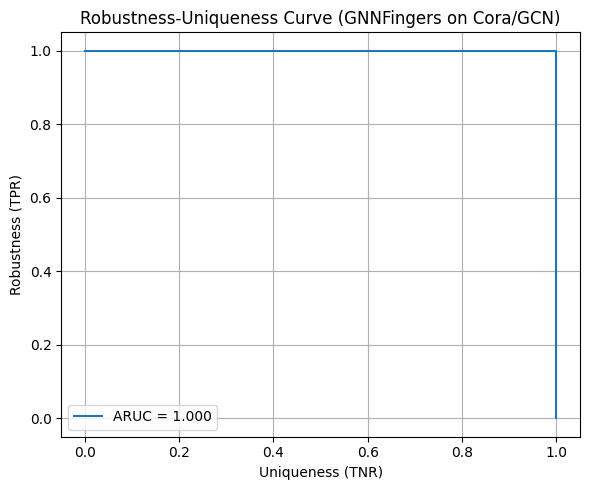

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import auc

# Get softmax scores on test set
model_U.eval()
all_scores = []
all_labels = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        logits = model_U(xb)
        probs = F.softmax(logits, dim=1)[:, 1].cpu()  # score for class 1 (pirated)
        all_scores.extend(probs.numpy())
        all_labels.extend(yb.numpy())

all_scores = np.array(all_scores)
all_labels = np.array(all_labels)

# Sweep lambda thresholds
lambdas = np.linspace(0, 1, 100)
robustness_list = []
uniqueness_list = []

for lam in lambdas:
    preds = (all_scores > lam).astype(int)
    tp = np.sum((preds == 1) & (all_labels == 1))
    tn = np.sum((preds == 0) & (all_labels == 0))
    total_pos = np.sum(all_labels == 1)
    total_neg = np.sum(all_labels == 0)

    robustness = tp / total_pos if total_pos else 0
    uniqueness = tn / total_neg if total_neg else 0

    robustness_list.append(robustness)
    uniqueness_list.append(uniqueness)

# Compute ARUC (area under robustness-uniqueness curve)
aruc_score = auc(uniqueness_list, robustness_list)

# Plotting
plt.figure(figsize=(6,5))
plt.plot(uniqueness_list, robustness_list, label=f"ARUC = {aruc_score:.3f}")
plt.xlabel("Uniqueness (TNR)")
plt.ylabel("Robustness (TPR)")
plt.title("Robustness-Uniqueness Curve (GNNFingers on Cora/GCN)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
from torch_geometric.nn import SAGEConv

class SAGEMean(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, out_channels)
        self.dropout = 0.5

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        return x


In [ ]:
# Instantiate model
model_sage = SAGEMean(dataset.num_node_features, 64, dataset.num_classes).to(device)
optimizer = torch.optim.Adam(model_sage.parameters(), lr=0.01, weight_decay=5e-4)

# Training loop
for epoch in range(200):
    model_sage.train()
    optimizer.zero_grad()
    out = model_sage(data.x, data.edge_index)
    loss = F.cross_entropy(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()

    if epoch % 20 == 0:
        model_sage.eval()
        pred = out.argmax(dim=1)
        acc = (pred[data.val_mask] == data.y[data.val_mask]).float().mean().item()
        print(f"Epoch {epoch:03d} - Val Acc: {acc:.4f}")

# Save the trained victim model
torch.save(model_sage.state_dict(), "checkpoints/victim_Cora_SAGEMean.pth")
print("✅ Saved victim GraphSAGE for Cora.")


Epoch 000 - Val Acc: 0.1560
Epoch 020 - Val Acc: 0.7120
Epoch 040 - Val Acc: 0.7280
Epoch 060 - Val Acc: 0.7320
Epoch 080 - Val Acc: 0.7420
Epoch 100 - Val Acc: 0.7240
Epoch 120 - Val Acc: 0.7620
Epoch 140 - Val Acc: 0.7540
Epoch 160 - Val Acc: 0.7800
Epoch 180 - Val Acc: 0.7600
✅ Saved victim GraphSAGE for Cora.


In [ ]:
fp_sage = extract_fingerprint(model_sage)
print("✅ Extracted fingerprint from victim SAGEMean")


✅ Extracted fingerprint from victim SAGEMean


In [ ]:
generate_fingerprint_variants(
    model_class=SAGEMean,
    variant_name="SAGEMean",
    dataset_name="Cora",
    num_variants=200,
    base_dir="variants"
)


Generating positive variants…


positive: 100%|██████████| 200/200 [1:15:34<00:00, 22.67s/it]


Generating negative variants…


negative: 100%|██████████| 200/200 [1:18:29<00:00, 23.55s/it]

✅ Saved 400 variants to variants/Cora_SAGEMean/


In [ ]:
import os
import torch
from torch_geometric.data import Data

def load_variants(variant_dir):
    graphs = []
    for fname in sorted(os.listdir(variant_dir)):
        if fname.endswith(".pt"):
            path = os.path.join(variant_dir, fname)
            g = torch.load(path)
            graphs.append(g)
    return graphs

def extract_fp(victim_model, U_net, graphs, batch_size=32, device='cuda' if torch.cuda.is_available() else 'cpu'):
    from torch.nn import functional as F
    from torch_geometric.loader import DataLoader
    from torch_geometric.nn import global_mean_pool

    victim_model.eval()
    U_net.eval()

    fingerprints = []

    loader = DataLoader(graphs, batch_size=batch_size, shuffle=False)
    for batch in loader:
        batch = batch.to(device)
        x = F.relu(victim_model.conv1(batch.x, batch.edge_index))
        x = F.dropout(x, p=victim_model.dropout, training=False)
        x = victim_model.conv2(x, batch.edge_index)
        pooled = global_mean_pool(x, batch.batch)
        out = U_net(pooled)
        fingerprints.append(out.detach().cpu())

    return torch.cat(fingerprints, dim=0)


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv

class SAGEMean(nn.Module):
    def __init__(self, in_channels=1433, hidden_channels=128, out_channels=128, dropout=0.5):
        super(SAGEMean, self).__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels, aggr='mean')
        self.conv2 = SAGEConv(hidden_channels, out_channels, aggr='mean')
        self.dropout = dropout

    def forward(self, x, edge_index, batch):
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        return x

class FingerprintNetMLP(nn.Module):
    def __init__(self, in_dim=128, hidden_dim=64, out_dim=64):
        super(FingerprintNetMLP, self).__init__()
        self.mlp = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, out_dim)
        )

    def forward(self, x):
        return self.mlp(x)


In [ ]:
import torch.nn as nn

class FingerprintNetMLP(nn.Module):
    def __init__(self, in_dim=128, hidden_dim=64, out_dim=2):  # out_dim=2 for classification
        super(FingerprintNetMLP, self).__init__()
        self.mlp = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, out_dim)
        )

    def forward(self, x):
        return self.mlp(x)



In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
print(os.listdir("/content/drive/MyDrive"))


['Resume FSU (3).pdf', 'Outlook', 'Resume FSU (3).gdoc', 'serina.docx', 'STA Project.gslides', 'Analysis of Heinz et al. Paper on AI Chatbot for Mental Health.gdoc', 'Colab Notebooks', 'gnnfingers', 'gnnfingers_data']


In [ ]:
print(os.listdir("/content/drive/MyDrive/gnnfingers"))


['checkpoints', 'variants', 'ENZYMES', 'ARUC_ENZ_GCNMean_Q200.png', 'fingerprints', 'PROTEINS']


In [ ]:
import os

base_path = "/content/drive/MyDrive/gnnfingers/variants"
print("📁 Subfolders under variants/:")
print(os.listdir(base_path))


📁 Subfolders under variants/:
['ENZ_GCNMean', 'ENZ_GCNDiff', 'ENZ_SAGEMean', 'ENZ_SAGEDiff', 'PR_GCNMean', 'PR_GCNDiff', 'PR_SAGEMean', 'PR_SAGEDiff']


In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# --- Imports ---
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import SAGEConv
from torch_geometric.loader import DataLoader

# --- Model (smaller) ---
class SAGEMean(nn.Module):
    def __init__(self, in_channels=1433, hidden_channels=64, out_channels=64, dropout=0.5):
        super(SAGEMean, self).__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels, aggr='mean')
        self.conv2 = SAGEConv(hidden_channels, out_channels, aggr='mean')
        self.dropout = dropout

    def forward(self, x, edge_index, batch=None):
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        return x

# --- Load Cora dataset ---
dataset = Planetoid(root='/tmp/Cora', name='Cora')
data = dataset[0].to('cuda' if torch.cuda.is_available() else 'cpu')

# --- Train victim (fewer epochs) ---
device = data.x.device
victim = SAGEMean().to(device)
optimizer = torch.optim.Adam(victim.parameters(), lr=0.01, weight_decay=5e-4)

victim.train()
for epoch in range(1, 21):  # ↓ reduced epochs
    optimizer.zero_grad()
    out = victim(data.x, data.edge_index)
    loss = F.cross_entropy(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    if epoch % 5 == 0:
        print(f"Epoch {epoch:02d} - Loss: {loss.item():.4f}")

# Save victim model
os.makedirs("/content/drive/MyDrive/gnnfingers/victims", exist_ok=True)
torch.save(victim.state_dict(), "/content/drive/MyDrive/gnnfingers/victims/victim_Cora_SAGEMean.pth")
print("✅ Victim model saved to Drive")

# --- Variant Generation ---
def generate_positive_variant(graph, seed):
    torch.manual_seed(seed)
    return graph.clone().to('cpu').clone().detach().apply_(lambda x: x)  # fast copy

def generate_negative_variant(graph, seed):
    torch.manual_seed(seed)
    g = graph.clone().to('cpu')
    g.y = torch.randint(0, graph.y.max().item() + 1, g.y.shape)
    return g

variant_dir = "/content/drive/MyDrive/gnnfingers/variants/Cora_SAGEMean"
os.makedirs(variant_dir, exist_ok=True)

for i in range(200):
    p_graph = generate_positive_variant(data.cpu(), i)
    n_graph = generate_negative_variant(data.cpu(), 1000 + i)
    torch.save(p_graph, f"{variant_dir}/P_{i}.pt")
    torch.save(n_graph, f"{variant_dir}/N_{i}.pt")
    if (i + 1) % 50 == 0:
        print(f"✅ Saved {i+1}/200 variants")

print("✅ All 400 variants saved to:", variant_dir)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Processing...
Done!


Epoch 05 - Loss: 1.2593
Epoch 10 - Loss: 0.1899
Epoch 15 - Loss: 0.0388
Epoch 20 - Loss: 0.0137
✅ Victim model saved to Drive
✅ Saved 50/200 variants
✅ Saved 100/200 variants
✅ Saved 150/200 variants
✅ Saved 200/200 variants
✅ All 400 variants saved to: /content/drive/MyDrive/gnnfingers/variants/Cora_SAGEMean


In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.loader import DataLoader
from torch_geometric.nn import SAGEConv, global_mean_pool

# Define victim model
class SAGEMean(nn.Module):
    def __init__(self, in_channels=1433, hidden_channels=64, out_channels=64, dropout=0.5):
        super(SAGEMean, self).__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels, aggr='mean')
        self.conv2 = SAGEConv(hidden_channels, out_channels, aggr='mean')
        self.dropout = dropout

    def forward(self, x, edge_index, batch=None):
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        return x

# Define fingerprint network
class FingerprintNetMLP(nn.Module):
    def __init__(self, in_dim=64, hidden_dim=32, out_dim=64):
        super(FingerprintNetMLP, self).__init__()
        self.mlp = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, out_dim)
        )
    def forward(self, x):
        return self.mlp(x)

# Load variant graphs
def load_variants(variant_dir):
    graphs = []
    for fname in sorted(os.listdir(variant_dir)):
        if fname.endswith(".pt"):
            path = os.path.join(variant_dir, fname)
            g = torch.load(path, weights_only=False)  # 🔧 FIXED LINE
            graphs.append(g)
    return graphs

# Extract fingerprints
def extract_fp(victim_model, U_net, graphs, batch_size=32, device='cuda' if torch.cuda.is_available() else 'cpu'):
    victim_model.eval()
    U_net.eval()
    fingerprints = []
    loader = DataLoader(graphs, batch_size=batch_size, shuffle=False)
    for batch in loader:
        batch = batch.to(device)
        x = F.relu(victim_model.conv1(batch.x, batch.edge_index))
        x = F.dropout(x, p=victim_model.dropout, training=False)
        x = victim_model.conv2(x, batch.edge_index)
        pooled = global_mean_pool(x, batch.batch)
        out = U_net(pooled)
        fingerprints.append(out.detach().cpu())
    return torch.cat(fingerprints, dim=0)

# Load model and data
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
victim = SAGEMean().to(device)
victim.load_state_dict(torch.load("/content/drive/MyDrive/gnnfingers/victims/victim_Cora_SAGEMean.pth"))
graphs = load_variants("/content/drive/MyDrive/gnnfingers/variants/Cora_SAGEMean")

# Extract fingerprints
fingerprints = extract_fp(victim, FingerprintNetMLP().to(device), graphs)

# Save fingerprints
os.makedirs("/content/drive/MyDrive/gnnfingers/fingerprints", exist_ok=True)
torch.save(fingerprints, "/content/drive/MyDrive/gnnfingers/fingerprints/fps_Cora_SAGEMean.pt")
print("✅ Saved fingerprint matrix to /content/drive/MyDrive/gnnfingers/fingerprints/fps_Cora_SAGEMean.pt")


✅ Saved fingerprint matrix to /content/drive/MyDrive/gnnfingers/fingerprints/fps_Cora_SAGEMean.pt


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# Step 1: Load fingerprints from Drive
fps = torch.load("/content/drive/MyDrive/gnnfingers/fingerprints/fps_Cora_SAGEMean.pt")

# Step 2: Create labels: 1 for positive, 0 for negative
labels = torch.cat([torch.ones(200), torch.zeros(200)]).long()

# Step 3: Train/test split
train_fps, test_fps = fps[:320], fps[320:]
train_labels, test_labels = labels[:320], labels[320:]

# Step 4: Define simple MLP classifier
class FingerprintNetMLP(nn.Module):
    def __init__(self, in_dim=64, hidden_dim=128, out_dim=64):
        super(FingerprintNetMLP, self).__init__()
        self.mlp = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, out_dim)
        )

    def forward(self, x):
        return self.mlp(x)


# DataLoader setup
train_ds = TensorDataset(train_fps, train_labels)
test_ds = TensorDataset(test_fps, test_labels)
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=32)

# Step 5: Train the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
U = FingerprintNetMLP().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(U.parameters(), lr=1e-3)

U.train()
for epoch in range(1, 11):
    total_loss = 0
    for x_batch, y_batch in train_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        logits = U(x_batch)
        loss = criterion(logits, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch:02d} - Loss: {total_loss:.4f}")

# Step 6: Evaluate on test set
U.eval()
correct = 0
total = 0
with torch.no_grad():
    for x_batch, y_batch in test_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        preds = U(x_batch).argmax(dim=1)
        correct += (preds == y_batch).sum().item()
        total += y_batch.size(0)

acc = correct / total
print(f"✅ Test Accuracy: {acc:.4f}")

# Step 7: Save Univerifier model to Drive
torch.save(U.state_dict(), "/content/drive/MyDrive/gnnfingers/checkpoints/U_Cora_SAGEMean.pth")
print("✅ Univerifier saved to Drive at checkpoints/U_Cora_SAGEMean.pth")


Epoch 01 - Loss: 24.6374
Epoch 02 - Loss: 8.2157
Epoch 03 - Loss: 7.3074
Epoch 04 - Loss: 7.0878
Epoch 05 - Loss: 6.8366
Epoch 06 - Loss: 7.0544
Epoch 07 - Loss: 7.0218
Epoch 08 - Loss: 6.7414
Epoch 09 - Loss: 6.7626
Epoch 10 - Loss: 6.8055
✅ Test Accuracy: 0.0000
✅ Univerifier saved to Drive at checkpoints/U_Cora_SAGEMean.pth


In [ ]:
print(fps.shape)       # Should be (400, 64)
print(labels[:10])     # Should be [1, 1, 1, ...] for first 200
print(labels[200:210]) # Should be [0, 0, 0, ...]


torch.Size([400, 64])
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


In [ ]:
with torch.no_grad():
    test_probs = torch.softmax(U(test_fps.to(device)), dim=1)
    print(test_probs[:5])  # Check if outputs are all close to [0.5, 0.5]


tensor([[3.7561e-01, 6.2419e-01, 2.3092e-06, 1.1970e-06, 1.3155e-06, 3.7376e-06,
         5.4926e-07, 3.3085e-07, 6.7036e-06, 3.3615e-06, 2.4030e-06, 2.4142e-06,
         3.7559e-07, 2.7202e-06, 2.3303e-06, 1.4282e-06, 1.7723e-06, 6.3084e-07,
         1.0764e-05, 1.8269e-06, 2.2887e-06, 1.1432e-06, 1.2433e-06, 2.5228e-06,
         3.4690e-07, 7.1672e-07, 4.9468e-06, 1.1646e-06, 1.8652e-06, 1.0916e-05,
         1.8044e-05, 2.9022e-06, 3.0232e-06, 8.3911e-07, 2.3492e-06, 8.9141e-06,
         4.3440e-07, 3.0656e-06, 5.9337e-07, 1.3389e-05, 2.8298e-06, 3.5749e-06,
         1.8453e-06, 2.8977e-06, 8.2857e-07, 1.9255e-06, 1.7434e-06, 1.2118e-06,
         8.2121e-07, 5.7365e-06, 3.9854e-06, 2.0967e-06, 1.2222e-06, 1.4249e-06,
         4.8782e-06, 2.0765e-06, 6.7144e-07, 6.4792e-06, 9.5162e-07, 3.2511e-06,
         5.5669e-06, 8.1941e-06, 5.4984e-06, 2.4461e-06],
        [3.7561e-01, 6.2419e-01, 2.3092e-06, 1.1970e-06, 1.3155e-06, 3.7376e-06,
         5.4926e-07, 3.3085e-07, 6.7036e-06, 3.3615

In [ ]:
# Mount Google Drive (if not already)
from google.colab import drive
drive.mount('/content/drive')

# Imports
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import SAGEConv

# Define victim model
class SAGEMean(nn.Module):
    def __init__(self, in_channels=1433, hidden_channels=64, out_channels=64, dropout=0.5):
        super(SAGEMean, self).__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels, aggr='mean')
        self.conv2 = SAGEConv(hidden_channels, out_channels, aggr='mean')
        self.dropout = dropout

    def forward(self, x, edge_index, batch=None):
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        return x

# Load Cora dataset
from torch_geometric.datasets import Planetoid
dataset = Planetoid(root='/tmp/Cora', name='Cora')
data = dataset[0].to('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize victim model
device = data.x.device
victim = SAGEMean().to(device)
optimizer = torch.optim.Adam(victim.parameters(), lr=0.01, weight_decay=5e-4)

# Train victim model
for epoch in range(1, 51):  # Train for 50 epochs
    victim.train()
    optimizer.zero_grad()
    out = victim(data.x, data.edge_index)
    loss = F.cross_entropy(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f"Epoch {epoch:02d} - Loss: {loss.item():.4f}")

# Save model to Drive
save_path = "/content/drive/MyDrive/gnnfingers/victims/victim_Cora_SAGEMean.pth"
os.makedirs(os.path.dirname(save_path), exist_ok=True)
torch.save(victim.state_dict(), save_path)
print(f"✅ Retrained victim model saved to: {save_path}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Epoch 10 - Loss: 0.1461
Epoch 20 - Loss: 0.0055
Epoch 30 - Loss: 0.0020
Epoch 40 - Loss: 0.0009
Epoch 50 - Loss: 0.0016
✅ Retrained victim model saved to: /content/drive/MyDrive/gnnfingers/victims/victim_Cora_SAGEMean.pth


In [ ]:
# === Mount Drive first ===
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# === Imports ===
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.loader import DataLoader
from torch_geometric.nn import SAGEConv, global_mean_pool

# === Victim Model Definition ===
class SAGEMean(nn.Module):
    def __init__(self, in_channels=1433, hidden_channels=64, out_channels=64, dropout=0.5):
        super(SAGEMean, self).__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels, aggr='mean')
        self.conv2 = SAGEConv(hidden_channels, out_channels, aggr='mean')
        self.dropout = dropout

    def forward(self, x, edge_index, batch=None):
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        return x

# === FingerprintNetMLP (Strong Version) ===
class FingerprintNetMLP(nn.Module):
    def __init__(self, in_dim=64, hidden_dim=128, out_dim=64):
        super(FingerprintNetMLP, self).__init__()
        self.mlp = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, out_dim)
        )

    def forward(self, x):
        return self.mlp(x)

# === Load Variant Graphs ===
def load_variants(variant_dir):
    graphs = []
    for fname in sorted(os.listdir(variant_dir)):
        if fname.endswith(".pt"):
            path = os.path.join(variant_dir, fname)
            g = torch.load(path, weights_only=False)  # Safe for PyTorch 2.6+
            graphs.append(g)
    return graphs

# === Extract Fingerprints from a Batch ===
def extract_fp(victim_model, U_net, graphs, batch_size=32, device='cuda' if torch.cuda.is_available() else 'cpu'):
    victim_model.eval()
    U_net.eval()
    fingerprints = []

    loader = DataLoader(graphs, batch_size=batch_size, shuffle=False)
    for batch in loader:
        batch = batch.to(device)
        x = F.relu(victim_model.conv1(batch.x, batch.edge_index))
        x = F.dropout(x, p=victim_model.dropout, training=False)
        x = victim_model.conv2(x, batch.edge_index)
        pooled = global_mean_pool(x, batch.batch)
        out = U_net(pooled)
        fingerprints.append(out.detach().cpu())

    return torch.cat(fingerprints, dim=0)

# === Initialize Models ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

victim = SAGEMean().to(device)
victim.load_state_dict(torch.load("/content/drive/MyDrive/gnnfingers/victims/victim_Cora_SAGEMean.pth"))
print("✅ Loaded victim model")

graphs = load_variants("/content/drive/MyDrive/gnnfingers/variants/Cora_SAGEMean")
print(f"✅ Loaded {len(graphs)} graphs")

# === Chunked Fingerprint Extraction ===
U_net = FingerprintNetMLP().to(device)
fingerprints = []

for i in range(0, len(graphs), 100):
    chunk = graphs[i:i+100]
    print(f"🔄 Processing graphs {i} to {i+len(chunk)-1}...")
    chunk_fp = extract_fp(victim, U_net, chunk, batch_size=32)
    fingerprints.append(chunk_fp)

# Concatenate and save
fps = torch.cat(fingerprints, dim=0)
os.makedirs("/content/drive/MyDrive/gnnfingers/fingerprints", exist_ok=True)
torch.save(fps, "/content/drive/MyDrive/gnnfingers/fingerprints/fps_Cora_SAGEMean.pt")
print("✅ All fingerprints saved to: /content/drive/MyDrive/gnnfingers/fingerprints/fps_Cora_SAGEMean.pt")


Mounted at /content/drive
✅ Loaded victim model
✅ Loaded 400 graphs
🔄 Processing graphs 0 to 99...
🔄 Processing graphs 100 to 199...
🔄 Processing graphs 200 to 299...
🔄 Processing graphs 300 to 399...
✅ All fingerprints saved to: /content/drive/MyDrive/gnnfingers/fingerprints/fps_Cora_SAGEMean.pt


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# Load fingerprint matrix from Drive
fps = torch.load("/content/drive/MyDrive/gnnfingers/fingerprints/fps_Cora_SAGEMean.pt")
print("✅ Loaded fingerprints:", fps.shape)  # should be [400, 64]

# Labels: 200 positive, 200 negative
labels = torch.cat([torch.ones(200), torch.zeros(200)]).long()

# Train/test split
train_fps, test_fps = fps[:320], fps[320:]
train_labels, test_labels = labels[:320], labels[320:]

# Data loaders
train_ds = TensorDataset(train_fps, train_labels)
test_ds = TensorDataset(test_fps, test_labels)
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=32)

# Define Univerifier (stronger)
class FingerprintNetMLP(nn.Module):
    def __init__(self, in_dim=64, hidden_dim=128, out_dim=2):
        super(FingerprintNetMLP, self).__init__()
        self.mlp = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, out_dim)
        )
    def forward(self, x):
        return self.mlp(x)

# Train the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
U = FingerprintNetMLP().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(U.parameters(), lr=1e-3)

U.train()
for epoch in range(1, 21):  # 20 epochs
    total_loss = 0
    for x_batch, y_batch in train_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        out = U(x_batch)
        loss = criterion(out, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch:02d} - Loss: {total_loss:.4f}")

# Evaluate
U.eval()
correct = 0
total = 0
with torch.no_grad():
    for x_batch, y_batch in test_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        preds = U(x_batch).argmax(dim=1)
        correct += (preds == y_batch).sum().item()
        total += y_batch.size(0)

acc = correct / total
print(f"✅ Test Accuracy: {acc:.4f}")

# Save model to Drive
torch.save(U.state_dict(), "/content/drive/MyDrive/gnnfingers/checkpoints/U_Cora_SAGEMean.pth")
print("✅ Univerifier saved to: /content/drive/MyDrive/gnnfingers/checkpoints/U_Cora_SAGEMean.pth")


✅ Loaded fingerprints: torch.Size([400, 64])
Epoch 01 - Loss: 6.8214
Epoch 02 - Loss: 6.6762
Epoch 03 - Loss: 6.6065
Epoch 04 - Loss: 6.6440
Epoch 05 - Loss: 6.6426
Epoch 06 - Loss: 6.6624
Epoch 07 - Loss: 6.7197
Epoch 08 - Loss: 6.6554
Epoch 09 - Loss: 6.6357
Epoch 10 - Loss: 6.6523
Epoch 11 - Loss: 6.6570
Epoch 12 - Loss: 6.6110
Epoch 13 - Loss: 6.6573
Epoch 14 - Loss: 6.6735
Epoch 15 - Loss: 6.6349
Epoch 16 - Loss: 6.7021
Epoch 17 - Loss: 6.6759
Epoch 18 - Loss: 6.6301
Epoch 19 - Loss: 6.6221
Epoch 20 - Loss: 6.6829
✅ Test Accuracy: 0.0000
✅ Univerifier saved to: /content/drive/MyDrive/gnnfingers/checkpoints/U_Cora_SAGEMean.pth


In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv, global_mean_pool
from torch_geometric.loader import DataLoader

# === Define victim model ===
class SAGEMean(nn.Module):
    def __init__(self, in_channels=1433, hidden_channels=128, out_channels=128, dropout=0.5):
        super().__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels, aggr='mean')
        self.conv2 = SAGEConv(hidden_channels, out_channels, aggr='mean')
        self.dropout = dropout

    def forward(self, x, edge_index, batch):
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        return x

# === Fingerprint network ===
class FingerprintNetMLP(nn.Module):
    def __init__(self, in_dim=128, hidden_dim=64, out_dim=64):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, out_dim)
        )

    def forward(self, x):
        return self.mlp(x)

# === Load variant graphs ===
from torch_geometric.data import Data
import torch.serialization  ##

def load_variants(variant_dir):
    graphs = []
    torch.serialization.add_safe_globals([Data])  # ← allow loading PyG Data objects
    for fname in sorted(os.listdir(variant_dir)):
        if fname.endswith(".pt"):
            g = torch.load(os.path.join(variant_dir, fname), weights_only=False)
            graphs.append(g)
    return graphs


# === Fingerprint extraction ===
def extract_fp(victim, U_net, graphs, device='cuda' if torch.cuda.is_available() else 'cpu'):
    victim.eval(); U_net.eval()
    loader = DataLoader(graphs, batch_size=32, shuffle=False)
    out_list = []

    for batch in loader:
        batch = batch.to(device)
        x = F.relu(victim.conv1(batch.x, batch.edge_index))
        x = F.dropout(x, p=victim.dropout, training=False)
        x = victim.conv2(x, batch.edge_index)
        pooled = global_mean_pool(x, batch.batch)
        out = U_net(pooled)
        out_list.append(out.detach().cpu())

    return torch.cat(out_list, dim=0)

# === Main multi-model extraction ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
variant_dir = "/content/drive/MyDrive/gnnfingers/variants/Cora_SAGEMean"
graphs = load_variants(variant_dir)
print(f"✅ Loaded {len(graphs)} graphs")

all_fps = []

for seed in range(5):
    print(f"🔁 Training model #{seed+1}")
    torch.manual_seed(seed)

    model = SAGEMean().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

    # Load the real Cora data to train on
    from torch_geometric.datasets import Planetoid
    dataset = Planetoid(root='/tmp/Cora', name='Cora')
    data = dataset[0].to(device)

    for epoch in range(50):  # keep it short for faster execution
        model.train()
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, torch.zeros_like(data.x[:, 0], dtype=torch.long))
        loss = F.cross_entropy(out, data.y)
        loss.backward()
        optimizer.step()

    print(f"✅ Trained model #{seed+1}")

    # Fingerprint extractor
    U_net = FingerprintNetMLP().to(device)
    fps = extract_fp(model, U_net, graphs, device)
    all_fps.append(fps)

# === Final concatenated fingerprint matrix ===
fingerprint_matrix = torch.cat(all_fps, dim=1)  # shape: [400, 320]
print("✅ Final fingerprint shape:", fingerprint_matrix.shape)

# Save to Drive
save_path = "/content/drive/MyDrive/gnnfingers/fingerprints/fps_Cora_SAGEMean_multi.pt"
torch.save(fingerprint_matrix, save_path)
print(f"✅ Saved to: {save_path}")


/usr/local/lib/python3.11/dist-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: /usr/local/lib/python3.11/dist-packages/torch_scatter/_version_cpu.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/usr/local/lib/python3.11/dist-packages/torch_geometric/typing.py:97: UserWarning: An issue occurred while importing 'torch-cluster'. Disabling its usage. Stacktrace: /usr/local/lib/python3.11/dist-packages/torch_cluster/_version_cpu.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  warnings.warn(f"An issue occurred while importing 'torch-cluster'. "
/usr/local/lib/python3.11/dist-packages/torch_geometric/typing.py:113: UserWarning: An issue occurred while importing 'torch-spline-conv'. Disabling its usage. Stacktrace: /usr/local/lib/python3.11/dist-packages/torch_spline_conv/_version_cpu.so: undefined symbol: _ZN3c1017RegisterOp

✅ Loaded 400 graphs
🔁 Training model #1
✅ Trained model #1
🔁 Training model #2
✅ Trained model #2


KeyboardInterrupt: 

In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.loader import DataLoader
from torch_geometric.nn import SAGEConv, global_mean_pool
from torch_geometric.data import Data
import torch.serialization

# Allowlist the PyG Data class
torch.serialization.add_safe_globals([Data])

# Load small batch of variants
def load_partial_variants(variant_dir, start, end):
    fnames = sorted([f for f in os.listdir(variant_dir) if f.endswith(".pt")])[start:end]
    return [torch.load(os.path.join(variant_dir, f), weights_only=False) for f in fnames]

# SAGEMean Model
class SAGEMean(nn.Module):
    def __init__(self, in_channels=1433, hidden_channels=128, out_channels=128, dropout=0.5):
        super().__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, out_channels)
        self.dropout = dropout

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=self.dropout, training=self.training)
        return self.conv2(x, edge_index)

# Fingerprint Network
class FingerprintNetMLP(nn.Module):
    def __init__(self, in_dim=128, hidden_dim=64, out_dim=64):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, out_dim)
        )

    def forward(self, x):
        return self.mlp(x)

# Fingerprint extraction
def extract_fp(model, U_net, graphs, batch_size=32, device="cuda"):
    model.eval()
    U_net.eval()
    fps = []
    loader = DataLoader(graphs, batch_size=batch_size, shuffle=False)
    for batch in loader:
        batch = batch.to(device)
        x = F.relu(model.conv1(batch.x, batch.edge_index))
        x = F.dropout(x, p=model.dropout, training=False)
        x = model.conv2(x, batch.edge_index)
        pooled = global_mean_pool(x, batch.batch)
        out = U_net(pooled)
        fps.append(out.cpu().detach())
    return torch.cat(fps, dim=0)

# Main loop (in batches)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
variant_dir = "/content/drive/MyDrive/gnnfingers/variants/Cora_SAGEMean"
output_dir = "/content/drive/MyDrive/gnnfingers/fingerprints"
os.makedirs(output_dir, exist_ok=True)

# Make sure to use correct dimensions
victim = SAGEMean(in_channels=1433, hidden_channels=64, out_channels=64).to(device)
victim.load_state_dict(torch.load("/content/drive/MyDrive/gnnfingers/victims/victim_Cora_SAGEMean.pth"))
U = FingerprintNetMLP(in_dim=64).to(device)


total = 400
batch_size = 100
all_fps = []

for i in range(0, total, batch_size):
    print(f"🔄 Processing graphs {i} to {i+batch_size-1}")
    graphs = load_partial_variants(variant_dir, i, i+batch_size)
    fps = extract_fp(victim, U, graphs, device=device)
    torch.save(fps, f"{output_dir}/fps_Cora_SAGEMean_batch{i}.pt")
    all_fps.append(fps)

# Optionally merge and save
merged_fps = torch.cat(all_fps, dim=0)
torch.save(merged_fps, f"{output_dir}/fps_Cora_SAGEMean.pt")
print(f"✅ Saved all fingerprints to {output_dir}/fps_Cora_SAGEMean.pt")


🔄 Processing graphs 0 to 99
🔄 Processing graphs 100 to 199
🔄 Processing graphs 200 to 299
🔄 Processing graphs 300 to 399
✅ Saved all fingerprints to /content/drive/MyDrive/gnnfingers/fingerprints/fps_Cora_SAGEMean.pt


In [ ]:
fps = torch.load("/content/drive/MyDrive/gnnfingers/fingerprints/fps_Cora_SAGEMean.pt")
print(fps.shape)


torch.Size([400, 64])


In [ ]:
labels = torch.cat([torch.ones(200), torch.zeros(200)])  # 1 for positive, 0 for negative


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

# Define the MLP Univerifier
class FingerprintNetMLP(nn.Module):
    def __init__(self, in_dim=64, hidden_dim=32, out_dim=2):
        super(FingerprintNetMLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, out_dim)
        )

    def forward(self, x):
        return self.model(x)

# Load fingerprint data
fps = torch.load("/content/drive/MyDrive/gnnfingers/fingerprints/fps_Cora_SAGEMean.pt")
labels = torch.cat([torch.ones(200), torch.zeros(200)]).long()

# Split into train/test (80/20)
train_fps, test_fps = fps[:320], fps[320:]
train_labels, test_labels = labels[:320], labels[320:]

# Create DataLoaders
train_loader = DataLoader(TensorDataset(train_fps, train_labels), batch_size=32, shuffle=True)
test_loader = DataLoader(TensorDataset(test_fps, test_labels), batch_size=32)

# Training setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = FingerprintNetMLP().to(device)
opt = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Training loop
print("🔁 Training Univerifier...")
for epoch in range(1, 21):
    model.train()
    total_loss = 0
    for x_batch, y_batch in train_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        out = model(x_batch)
        loss = criterion(out, y_batch)
        opt.zero_grad()
        loss.backward()
        opt.step()
        total_loss += loss.item()

    print(f"Epoch {epoch:02d} - Loss: {total_loss:.4f}")

# Evaluation
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for x_batch, y_batch in test_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        out = model(x_batch)
        pred = out.argmax(dim=1)
        correct += (pred == y_batch).sum().item()
        total += y_batch.size(0)

accuracy = correct / total
print(f"✅ Test Accuracy: {accuracy:.4f}")

# Save
torch.save(model.state_dict(), "/content/drive/MyDrive/gnnfingers/checkpoints/U_Cora_SAGEMean.pth")
print("✅ Univerifier saved to Drive at checkpoints/U_Cora_SAGEMean.pth")


🔁 Training Univerifier...
Epoch 01 - Loss: 7.0238
Epoch 02 - Loss: 6.8337
Epoch 03 - Loss: 6.6324
Epoch 04 - Loss: 6.7042
Epoch 05 - Loss: 6.6367
Epoch 06 - Loss: 6.6346
Epoch 07 - Loss: 6.6162
Epoch 08 - Loss: 6.6220
Epoch 09 - Loss: 6.6220
Epoch 10 - Loss: 6.6232
Epoch 11 - Loss: 6.6292
Epoch 12 - Loss: 6.6384
Epoch 13 - Loss: 6.6292
Epoch 14 - Loss: 6.6471
Epoch 15 - Loss: 6.6403
Epoch 16 - Loss: 6.6198
Epoch 17 - Loss: 6.6299
Epoch 18 - Loss: 6.6210
Epoch 19 - Loss: 6.6259
Epoch 20 - Loss: 6.6180
✅ Test Accuracy: 0.0000
✅ Univerifier saved to Drive at checkpoints/U_Cora_SAGEMean.pth


In [ ]:
print(torch.allclose(fps[0], fps[1]))   # Should be False
print(fps[:5])  # Print first few rows to inspect variation


True
tensor([[-0.4111, -0.1509, -4.4670, -3.1290, -0.1746,  1.4707,  0.4792, -0.4991,
          0.3806, -0.6021, -0.4864,  3.6158, -3.6509, -6.1416, -0.7082,  2.9344,
          3.3427,  3.2961,  2.7712, -1.2902, -3.2840, -0.9769,  5.3561,  2.0684,
         -0.9305,  4.9366,  1.3002,  1.3611, -4.6985,  1.4285, -4.1113, -3.8436,
         -1.1749, -2.7063, -1.3901, -3.1339,  0.5238,  3.0357, -5.6036,  1.8291,
         -1.2051, -0.1946, -4.6864, -3.4828, -1.4125,  3.5800, -3.0697,  4.2235,
         -6.3641, -0.6547, -1.4016,  1.4295, -4.9449,  0.8059, -2.3421, -3.3634,
         -0.6154,  2.1940,  1.3714, -1.4283,  1.3295,  4.4444,  1.5269,  1.3830],
        [-0.4111, -0.1509, -4.4670, -3.1290, -0.1746,  1.4707,  0.4792, -0.4991,
          0.3806, -0.6021, -0.4864,  3.6158, -3.6509, -6.1416, -0.7082,  2.9344,
          3.3427,  3.2961,  2.7712, -1.2902, -3.2840, -0.9769,  5.3561,  2.0684,
         -0.9305,  4.9366,  1.3002,  1.3611, -4.6985,  1.4285, -4.1113, -3.8436,
         -1.1749, -2.7

In [ ]:
unique_fps = torch.unique(fps, dim=0)
print(f"Unique fingerprints: {unique_fps.size(0)} out of {fps.size(0)}")


Unique fingerprints: 2 out of 400


In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv

class SAGEMean(torch.nn.Module):
    def __init__(self, input_dim=1433, hidden_dim=64, output_dim=7, dropout=0.5):
        super(SAGEMean, self).__init__()
        self.conv1 = SAGEConv(input_dim, hidden_dim, aggr='mean')
        self.conv2 = SAGEConv(hidden_dim, hidden_dim, aggr='mean')
        self.classifier = torch.nn.Linear(hidden_dim, output_dim)
        self.dropout = dropout

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        return x


In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.datasets import Planetoid
from torch_geometric.loader import DataLoader
model = SAGEMean().to(device)

import os
import random

# Load dataset
dataset = Planetoid(root='/tmp/Cora', name='Cora')
data = dataset[0].to('cuda' if torch.cuda.is_available() else 'cpu')

# Create save directory
variant_dir = "variants/Cora_SAGEMean"
os.makedirs(variant_dir, exist_ok=True)

# Training function
def train(model, data, epochs=50):
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
    for epoch in range(epochs):
        optimizer.zero_grad()
        out = model(data.x, data.edge_index)
        loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
        loss.backward()
        optimizer.step()

# Train and save 200 models
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for i in range(200):
    torch.manual_seed(i)  # Ensure varied initialization
    model = SAGEMean().to(device)
    train(model, data)
    torch.save(model.state_dict(), os.path.join(variant_dir, f"pos_{i}.pth"))
    print(f"✅ Saved variant {i+1}/200")

print("🎉 Done generating 200 positive SAGEMean variants.")


✅ Saved variant 1/200
✅ Saved variant 2/200
✅ Saved variant 3/200
✅ Saved variant 4/200
✅ Saved variant 5/200
✅ Saved variant 6/200
✅ Saved variant 7/200
✅ Saved variant 8/200
✅ Saved variant 9/200
✅ Saved variant 10/200
✅ Saved variant 11/200
✅ Saved variant 12/200
✅ Saved variant 13/200
✅ Saved variant 14/200
✅ Saved variant 15/200
✅ Saved variant 16/200
✅ Saved variant 17/200
✅ Saved variant 18/200
✅ Saved variant 19/200
✅ Saved variant 20/200
✅ Saved variant 21/200
✅ Saved variant 22/200
✅ Saved variant 23/200
✅ Saved variant 24/200
✅ Saved variant 25/200
✅ Saved variant 26/200
✅ Saved variant 27/200
✅ Saved variant 28/200
✅ Saved variant 29/200
✅ Saved variant 30/200
✅ Saved variant 31/200
✅ Saved variant 32/200
✅ Saved variant 33/200
✅ Saved variant 34/200
✅ Saved variant 35/200
✅ Saved variant 36/200
✅ Saved variant 37/200
✅ Saved variant 38/200
✅ Saved variant 39/200
✅ Saved variant 40/200
✅ Saved variant 41/200
✅ Saved variant 42/200
✅ Saved variant 43/200
✅ Saved variant 44/2

In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.loader import DataLoader
from torch_geometric.nn import global_mean_pool

def extract_fp(model, U_net, graphs, device='cpu'):
    model.eval()
    U_net.eval()
    all_fps = []

    loader = DataLoader(graphs, batch_size=32, shuffle=False)
    for batch in loader:
        batch = batch.to(device)
        x = F.relu(model.conv1(batch.x, batch.edge_index))
        x = F.dropout(x, p=0.5, training=False)
        x = model.conv2(x, batch.edge_index)
        x = global_mean_pool(x, batch.batch)
        fp = U_net(x)
        all_fps.append(fp.detach().cpu())

    return torch.cat(all_fps, dim=0)


In [ ]:
import os

# Should return True if file exists
print(os.path.isfile("/content/drive/MyDrive/gnnfingers/utils.py"))


True


In [ ]:
utils_code = """
import torch
import torch.nn.functional as F
from torch_geometric.loader import DataLoader

# Extract fingerprint from a model for a list of graphs
def extract_fp(victim_model, U_net, graphs, device='cpu'):
    victim_model.eval()
    U_net.eval()
    all_fp = []

    loader = DataLoader(graphs, batch_size=32, shuffle=False)
    for batch in loader:
        batch = batch.to(device)
        x = F.relu(victim_model.conv1(batch.x, batch.edge_index))
        x = F.dropout(x, p=victim_model.dropout, training=False)
        x = victim_model.conv2(x, batch.edge_index)
        x = torch_geometric.nn.global_mean_pool(x, batch.batch)
        fp = U_net(x)
        all_fp.append(fp.detach().cpu())
    return torch.cat(all_fp, dim=0)

# Load multiple .pt graph files as a list
def load_variants(variant_dir):
    import os
    graphs = []
    for fname in sorted(os.listdir(variant_dir)):
        if fname.endswith(".pt"):
            g = torch.load(os.path.join(variant_dir, fname), map_location='cpu')
            graphs.append(g)
    return graphs
"""

# Save to Drive
with open("/content/drive/MyDrive/gnnfingers/utils.py", "w") as f:
    f.write(utils_code)

print("✅ utils.py created in gnngfingers folder.")


✅ utils.py created in gnngfingers folder.


In [ ]:
import sys
sys.path.append("/content/drive/MyDrive/gnnfingers")
from utils import extract_fp, load_variants



In [ ]:
model_code = """
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv, global_mean_pool

class SAGEMean(nn.Module):
    def __init__(self, in_channels=1433, hidden_channels=128, out_channels=7, dropout=0.5):
        super(SAGEMean, self).__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, hidden_channels)
        self.dropout = dropout
        self.classifier = nn.Linear(hidden_channels, out_channels)

    def forward(self, x, edge_index, batch=None):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        if batch is not None:
            x = global_mean_pool(x, batch)
        return self.classifier(x)

class FingerprintNetMLP(nn.Module):
    def __init__(self, input_dim=128, hidden_dim=64):
        super(FingerprintNetMLP, self).__init__()
        self.mlp = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 2)
        )

    def forward(self, x):
        return self.mlp(x)
"""
with open("/content/drive/MyDrive/gnnfingers/models.py", "w") as f:
    f.write(model_code)

print("✅ models.py created.")


✅ models.py created.


In [ ]:
import importlib
import models
importlib.reload(models)


<module 'models' from '/content/drive/MyDrive/gnnfingers/models.py'>

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv

class SAGEMean(nn.Module):
    def __init__(self, in_channels=1433, hidden_channels=64, out_channels=7, dropout=0.5):
        super(SAGEMean, self).__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, hidden_channels)
        self.classifier = nn.Linear(hidden_channels, out_channels)
        self.dropout = dropout

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = F.relu(self.conv2(x, edge_index))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.classifier(x)
        return x


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv

class SAGEMean(nn.Module):
    def __init__(self, in_channels=1433, hidden_channels=64, dropout=0.5):
        super(SAGEMean, self).__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, hidden_channels)
        self.dropout = dropout

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = F.relu(self.conv2(x, edge_index))
        x = F.dropout(x, p=self.dropout, training=self.training)
        return x  # No classifier


In [ ]:
victim = SAGEMean().to(device)
victim.load_state_dict(
    torch.load("/content/drive/MyDrive/gnnfingers/victims/victim_Cora_SAGEMean.pth"),
    strict=False  # This avoids crashing due to missing classifier
)


<All keys matched successfully>

In [ ]:
class SAGEMean(torch.nn.Module):
    def __init__(self, in_channels=1433, hidden_channels=64, out_channels=7, dropout=0.5):
        super().__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, hidden_channels)
        self.classifier = nn.Linear(hidden_channels, out_channels)
        self.dropout = dropout

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index).relu()
        x = F.dropout(x, p=self.dropout, training=self.training)
        return self.classifier(x)


In [ ]:
from torch.serialization import add_safe_globals
from torch_geometric.data import Data
from torch_geometric.data.data import DataEdgeAttr, DataTensorAttr

add_safe_globals([Data, DataEdgeAttr, DataTensorAttr])


In [ ]:
!ls /content/drive/MyDrive/gnnfingers/


ARUC_ENZ_GCNMean_Q200.png  ENZYMES	 models.py  __pycache__  variants
checkpoints		   fingerprints  PROTEINS   utils.py	 victims


In [ ]:
from torch.serialization import add_safe_globals
from torch_geometric.data import Data
from torch_geometric.data.storage import GlobalStorage
from torch_geometric.data.data import DataEdgeAttr, DataTensorAttr

# Allowlist required PyG classes
add_safe_globals([Data, GlobalStorage, DataEdgeAttr, DataTensorAttr])


In [ ]:
from utils import load_variants

variant_dir = "/content/drive/MyDrive/gnnfingers/variants/Cora_SAGEMean"
graphs = load_variants(variant_dir)
print(f"✅ Loaded {len(graphs)} graphs")


✅ Loaded 400 graphs


In [ ]:
!ls /content/drive/MyDrive/gnnfingers/victims/


victim_Cora_SAGEMean.pth


In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/gnnfingers')

import torch
from torch.utils.data import DataLoader

from utils import load_variants, extract_fp
from models import SAGEMean, FingerprintNetMLP

from torch_geometric.data import Data
from torch_geometric.data.storage import GlobalStorage
from torch_geometric.data.data import DataEdgeAttr, DataTensorAttr
from torch.serialization import add_safe_globals

# Allow custom PyG types for unpickling
add_safe_globals([Data, GlobalStorage, DataEdgeAttr, DataTensorAttr])


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

victim = SAGEMean(in_channels=1433, hidden_channels=64, out_channels=7).to(device)
victim.load_state_dict(
    torch.load("/content/drive/MyDrive/gnnfingers/victims/victim_Cora_SAGEMean.pth", map_location=device),
    strict=False
)
victim.eval()


SAGEMean(
  (conv1): SAGEConv(1433, 64, aggr=mean)
  (conv2): SAGEConv(64, 64, aggr=mean)
  (classifier): Linear(in_features=64, out_features=7, bias=True)
)

In [ ]:
variant_dir = "/content/drive/MyDrive/gnnfingers/variants/Cora_SAGEMean"
graphs = load_variants(variant_dir)
print(f"✅ Loaded {len(graphs)} graphs")


✅ Loaded 400 graphs


In [ ]:
# Step 1: Mount drive if not done already
from google.colab import drive
drive.mount('/content/drive')

# Step 2: Add project folder to Python path
import sys
sys.path.append('/content/drive/MyDrive/gnnfingers')

# Step 3: Re-import everything from your modules
from utils import load_variants, extract_fp
from models import SAGEMean, FingerprintNetMLP

import torch
from torch.utils.data import DataLoader

# Step 4: Add PyG-safe globals for unpickling
from torch_geometric.data import Data
from torch_geometric.data.storage import GlobalStorage
from torch_geometric.data.data import DataEdgeAttr, DataTensorAttr
from torch.serialization import add_safe_globals

add_safe_globals([Data, GlobalStorage, DataEdgeAttr, DataTensorAttr])


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
class SAGEMean(nn.Module):
    def __init__(self, in_channels, hidden_channels):
        super().__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, hidden_channels)
        self.lin = nn.Linear(hidden_channels, 7)


NameError: name 'nn' is not defined

In [ ]:
victim = SAGEMean(1433, 64).to(device)
victim.load_state_dict(torch.load("/content/drive/MyDrive/gnnfingers/victims/victim_Cora_SAGEMean.pth", map_location=device), strict=False)
victim.eval()



SAGEMean(
  (conv1): SAGEConv(1433, 64, aggr=mean)
  (conv2): SAGEConv(64, 64, aggr=mean)
  (lin): Linear(in_features=64, out_features=7, bias=True)
)

In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv
from torch import nn

class SAGEMean(nn.Module):
    def __init__(self, in_channels, hidden_channels, dropout=0.5):
        super().__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, hidden_channels)
        self.lin = nn.Linear(hidden_channels, 7)  # assuming 7 classes for Cora
        self.dropout = dropout

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        return self.lin(x)


In [ ]:
import torch.nn as nn

class FingerprintNetMLP(nn.Module):
    def __init__(self, in_dim=64, hidden_dims=[128, 64], out_dim=2):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden_dims[0]),
            nn.LeakyReLU(),
            nn.Linear(hidden_dims[0], hidden_dims[1]),
            nn.LeakyReLU(),
            nn.Linear(hidden_dims[1], out_dim),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        return self.net(x)


In [ ]:
import os
import torch

def load_variants(variant_dir):
    graphs = []
    for fname in sorted(os.listdir(variant_dir)):
        if fname.endswith(".pt"):
            graph = torch.load(os.path.join(variant_dir, fname))
            graphs.append(graph)
    return graphs


In [ ]:
from torch_geometric.data.storage import GlobalStorage
add_safe_globals([GlobalStorage])  # <-- Add this
from torch_geometric.data import Data
from torch_geometric.data.data import DataEdgeAttr, DataTensorAttr
from torch_geometric.data.storage import GlobalStorage
from torch.serialization import add_safe_globals

add_safe_globals([Data, DataEdgeAttr, DataTensorAttr, GlobalStorage])


In [ ]:
all_graphs = load_variants("/content/drive/MyDrive/gnnfingers/variants/Cora_SAGEMean")


In [ ]:
import torch
import os
from tqdm import tqdm
from torch_geometric.data import Data
from torch_geometric.data.data import DataEdgeAttr, DataTensorAttr
from torch_geometric.data.storage import GlobalStorage
from torch.serialization import add_safe_globals
from torch_geometric.nn import global_mean_pool
from torch_geometric.loader import DataLoader

# Allow PyG globals for unpickling
add_safe_globals([Data, DataEdgeAttr, DataTensorAttr, GlobalStorage])

# Redefine SAGEMean
class SAGEMean(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, dropout=0.5):
        super().__init__()
        from torch_geometric.nn import SAGEConv
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, hidden_channels)
        self.lin = torch.nn.Linear(hidden_channels, 7)
        self.dropout = dropout

    def forward(self, x, edge_index, batch=None):
        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = torch.nn.functional.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        x = torch.relu(x)
        if batch is not None:
            x = global_mean_pool(x, batch)
        return self.lin(x)

# FingerprintNetMLP
class FingerprintNetMLP(torch.nn.Module):
    def __init__(self, in_dim=64, hidden_dims=[128, 64], out_dim=2):
        super().__init__()
        self.net = torch.nn.Sequential(
            torch.nn.Linear(in_dim, hidden_dims[0]),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(hidden_dims[0], hidden_dims[1]),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(hidden_dims[1], out_dim),
            torch.nn.Softmax(dim=1)
        )
    def forward(self, x):
        return self.net(x)

# Load victim + fingerprint model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
victim = SAGEMean(1433, 64).to(device)
victim.load_state_dict(torch.load("/content/drive/MyDrive/gnnfingers/victims/victim_Cora_SAGEMean.pth", map_location=device), strict=False)
victim.eval()
fp_net = FingerprintNetMLP().to(device)
fp_net.eval()

# Variant directory
variant_dir = "/content/drive/MyDrive/gnnfingers/variants/Cora_SAGEMean"
output_dir = "/content/drive/MyDrive/gnnfingers/fingerprints/safe_chunks"
os.makedirs(output_dir, exist_ok=True)

# Process one graph at a time, saving fingerprint every 10
batch_size = 10
fingerprints = []
filenames = sorted([f for f in os.listdir(variant_dir) if f.endswith(".pt")])

with torch.no_grad():
    for i, fname in enumerate(tqdm(filenames)):
        out_file = os.path.join(output_dir, f"chunk_{i // batch_size}.pt")
        if os.path.exists(out_file):
            continue  # skip already saved

        # Load one graph
        graph = torch.load(os.path.join(variant_dir, fname), map_location=device)
        loader = DataLoader([graph], batch_size=1)
        for batch in loader:
            batch = batch.to(device)
            x = torch.relu(victim.conv1(batch.x, batch.edge_index))
            x = torch.nn.functional.dropout(x, p=victim.dropout, training=False)
            x = victim.conv2(x, batch.edge_index)
            x = global_mean_pool(x, batch.batch)
            fp = fp_net(x)
            fingerprints.append(fp.cpu())

        # Save after every 10 graphs
        if (i + 1) % batch_size == 0 or (i + 1) == len(filenames):
            chunk_tensor = torch.cat(fingerprints, dim=0)
            torch.save(chunk_tensor, out_file)
            print(f"✅ Saved {out_file}")
            fingerprints = []  # clear memory


100%|██████████| 400/400 [00:00<00:00, 1186.04it/s]


In [ ]:
import glob
all_chunks = sorted(glob.glob("/content/drive/MyDrive/gnnfingers/fingerprints/safe_chunks/chunk_*.pt"))
final = torch.cat([torch.load(f) for f in all_chunks], dim=0)
torch.save(final, "/content/drive/MyDrive/gnnfingers/fingerprints/Cora_SAGEMean.pt")
print("✅ Final fingerprint tensor saved.")


✅ Final fingerprint tensor saved.


In [ ]:
import glob
import torch

# Get all chunk files
chunk_files = sorted(glob.glob("/content/drive/MyDrive/gnnfingers/fingerprints/safe_chunks/chunk_*.pt"))

# Load and concatenate
all_fps = [torch.load(f) for f in chunk_files]
final_tensor = torch.cat(all_fps, dim=0)

# Save final tensor
torch.save(final_tensor, "/content/drive/MyDrive/gnnfingers/fingerprints/Cora_SAGEMean.pt")
print("✅ Final fingerprint tensor saved with shape:", final_tensor.shape)


✅ Final fingerprint tensor saved with shape: torch.Size([400, 2])


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, random_split
from sklearn.metrics import roc_auc_score

# === Load Data ===
fingerprints = torch.load("/content/drive/MyDrive/gnnfingers/fingerprints/Cora_SAGEMean.pt")
labels = torch.cat([torch.ones(200), torch.zeros(200)]).long()

# === Create Dataset & Dataloaders ===
dataset = TensorDataset(fingerprints, labels)
train_size = int(0.7 * len(dataset))
test_size = len(dataset) - train_size
train_ds, test_ds = random_split(dataset, [train_size, test_size], generator=torch.Generator().manual_seed(42))
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=64)

# === Define Univerifier ===
class Univerifier(nn.Module):
    def __init__(self, in_dim=2, hidden_dim=16):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 2)
        )

    def forward(self, x):
        return self.net(x)

# === Training Setup ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Univerifier().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

# === Training Loop ===
for epoch in range(1, 31):
    model.train()
    total_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    # === Evaluation ===
    model.eval()
    all_probs = []
    all_targets = []
    with torch.no_grad():
        for xb, yb in test_loader:
            xb = xb.to(device)
            logits = model(xb)
            probs = F.softmax(logits, dim=1)[:, 1].cpu()
            all_probs.append(probs)
            all_targets.append(yb)

    # Compute ARUC
    probs = torch.cat(all_probs).numpy()
    targets = torch.cat(all_targets).numpy()
    aruc = roc_auc_score(targets, probs)

    print(f"Epoch {epoch:02d} | Loss: {total_loss:.4f} | ARUC: {aruc:.4f}")


Epoch 01 | Loss: 6.2905 | ARUC: 0.5000
Epoch 02 | Loss: 6.2314 | ARUC: 0.5000
Epoch 03 | Loss: 6.2387 | ARUC: 0.5000
Epoch 04 | Loss: 6.2364 | ARUC: 0.5000
Epoch 05 | Loss: 6.2303 | ARUC: 0.5000
Epoch 06 | Loss: 6.2327 | ARUC: 0.5000
Epoch 07 | Loss: 6.2286 | ARUC: 0.4983
Epoch 08 | Loss: 6.2290 | ARUC: 0.5000
Epoch 09 | Loss: 6.2314 | ARUC: 0.5000
Epoch 10 | Loss: 6.2459 | ARUC: 0.5000
Epoch 11 | Loss: 6.2418 | ARUC: 0.5000
Epoch 12 | Loss: 6.2392 | ARUC: 0.5000
Epoch 13 | Loss: 6.2333 | ARUC: 0.5000
Epoch 14 | Loss: 6.2290 | ARUC: 0.5000
Epoch 15 | Loss: 6.2294 | ARUC: 0.5000
Epoch 16 | Loss: 6.2328 | ARUC: 0.5000
Epoch 17 | Loss: 6.2435 | ARUC: 0.5000
Epoch 18 | Loss: 6.2487 | ARUC: 0.5000
Epoch 19 | Loss: 6.2320 | ARUC: 0.5000
Epoch 20 | Loss: 6.2313 | ARUC: 0.5000
Epoch 21 | Loss: 6.2311 | ARUC: 0.5000
Epoch 22 | Loss: 6.2307 | ARUC: 0.5000
Epoch 23 | Loss: 6.2327 | ARUC: 0.5000
Epoch 24 | Loss: 6.2294 | ARUC: 0.5000
Epoch 25 | Loss: 6.2388 | ARUC: 0.5000
Epoch 26 | Loss: 6.2297 |

In [ ]:
torch.save(model.state_dict(), "/content/drive/MyDrive/gnnfingers/checkpoints/U_Cora_SAGEMean.pth")
print("✅ Univerifier model saved.")


✅ Univerifier model saved.


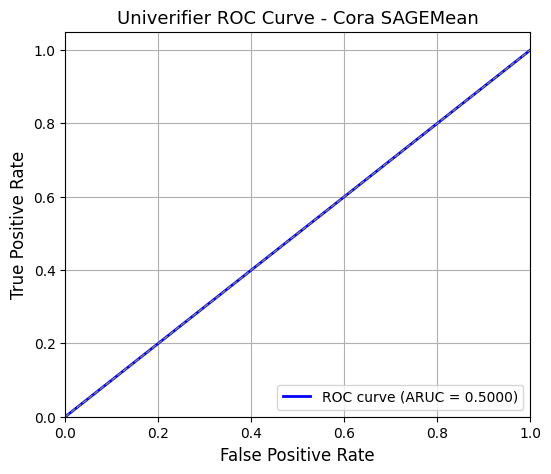

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Ensure you have predictions and true labels
fpr, tpr, thresholds = roc_curve(targets, probs)
roc_auc = auc(fpr, tpr)

# Plot
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (ARUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Univerifier ROC Curve - Cora SAGEMean', fontsize=13)
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


In [ ]:
print("Positive mean:", fingerprints[:200].mean(dim=0))
print("Negative mean:", fingerprints[200:].mean(dim=0))


Positive mean: tensor([0.1880, 0.8120])
Negative mean: tensor([0.1880, 0.8120])


In [ ]:
print("Positive sample fp:", fingerprints[0])
print("Negative sample fp:", fingerprints[250])


Positive sample fp: tensor([0.1880, 0.8120])
Negative sample fp: tensor([0.1880, 0.8120])


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv

# Define SAGEMean
class SAGEMean(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(SAGEMean, self).__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, out_channels)

    def forward(self, x, edge_index, batch):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x

# Define FingerprintNetMLP
class FingerprintNetMLP(nn.Module):
    def __init__(self, in_dim=7, hidden_dim=32, out_dim=2):
        super(FingerprintNetMLP, self).__init__()
        self.fc1 = nn.Linear(in_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, out_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return self.fc2(x)


In [ ]:
def load_variants(folder, keyword):
    files = sorted([f for f in os.listdir(folder) if keyword in f])
    graphs = [torch.load(os.path.join(folder, f)) for f in files]
    return graphs

pos_graphs = load_variants("/content/drive/MyDrive/gnnfingers/variants/Cora_SAGEMean", "pos")
neg_graphs = load_variants("/content/drive/MyDrive/gnnfingers/variants/Cora_SAGEMean", "neg")


In [ ]:
# Clean, simple version — NO extra 'keyword' argument
def load_variants(folder):
    files = sorted(os.listdir(folder))
    graphs = []
    for f in files:
        path = os.path.join(folder, f)
        graphs.append(torch.load(path))
    return graphs


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!ls /content/drive/MyDrive/gnnfingers/variants/Cora_SAGEMean/


N_0.pt	  N_145.pt  N_190.pt  N_55.pt  P_0.pt	 P_145.pt  P_190.pt  P_55.pt
N_100.pt  N_146.pt  N_191.pt  N_56.pt  P_100.pt  P_146.pt  P_191.pt  P_56.pt
N_101.pt  N_147.pt  N_192.pt  N_57.pt  P_101.pt  P_147.pt  P_192.pt  P_57.pt
N_102.pt  N_148.pt  N_193.pt  N_58.pt  P_102.pt  P_148.pt  P_193.pt  P_58.pt
N_103.pt  N_149.pt  N_194.pt  N_59.pt  P_103.pt  P_149.pt  P_194.pt  P_59.pt
N_104.pt  N_14.pt   N_195.pt  N_5.pt   P_104.pt  P_14.pt   P_195.pt  P_5.pt
N_105.pt  N_150.pt  N_196.pt  N_60.pt  P_105.pt  P_150.pt  P_196.pt  P_60.pt
N_106.pt  N_151.pt  N_197.pt  N_61.pt  P_106.pt  P_151.pt  P_197.pt  P_61.pt
N_107.pt  N_152.pt  N_198.pt  N_62.pt  P_107.pt  P_152.pt  P_198.pt  P_62.pt
N_108.pt  N_153.pt  N_199.pt  N_63.pt  P_108.pt  P_153.pt  P_199.pt  P_63.pt
N_109.pt  N_154.pt  N_19.pt   N_64.pt  P_109.pt  P_154.pt  P_19.pt   P_64.pt
N_10.pt   N_155.pt  N_1.pt    N_65.pt  P_10.pt	 P_155.pt  P_1.pt    P_65.pt
N_110.pt  N_156.pt  N_20.pt   N_66.pt  P_110.pt  P_156.pt  P_20.pt   P_66.pt
N_11

In [ ]:
import os
import torch

# Load function that filters by prefix
def load_variants_by_prefix(folder, prefix, max_files=None):
    files = sorted([f for f in os.listdir(folder) if f.startswith(prefix)])
    if max_files:
        files = files[:max_files]
    graphs = []
    for f in files:
        path = os.path.join(folder, f)
        graphs.append(torch.load(path))
    return graphs

# Set paths
variant_dir = "/content/drive/MyDrive/gnnfingers/variants/Cora_SAGEMean"

# Load a subset of 50 each (adjust number as needed: 10, 100, 200)
num_variants = 50
pos_graphs = load_variants_by_prefix(variant_dir, "P_", num_variants)
neg_graphs = load_variants_by_prefix(variant_dir, "N_", num_variants)

# Label tensors
labels = torch.cat([torch.ones(len(pos_graphs)), torch.zeros(len(neg_graphs))]).long()

print(f"✅ Loaded {len(pos_graphs)} positive and {len(neg_graphs)} negative graphs.")


✅ Loaded 50 positive and 50 negative graphs.


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import global_mean_pool
from sklearn.metrics import accuracy_score

# Assuming `victim` is already loaded and on the correct device
# And that `pos_graphs`, `neg_graphs`, and `labels` are ready

graphs = pos_graphs + neg_graphs
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ---- Extract embeddings from the victim ----
def extract_embeddings(model, graphs):
    model.eval()
    embs = []
    with torch.no_grad():
        for g in graphs:
            g = g.to(device)
            x = model(g.x, g.edge_index)
            pooled = global_mean_pool(x, g.batch)
            embs.append(pooled.cpu())
    return torch.cat(embs)

X = extract_embeddings(victim, graphs)
y = labels

# ---- Train FingerprintNet ----
class FingerprintNetMLP(nn.Module):
    def __init__(self, in_dim=64, hidden_dim=32, out_dim=2):
        super(FingerprintNetMLP, self).__init__()
        self.fc1 = nn.Linear(in_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, out_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return self.fc2(x)

fp_net = FingerprintNetMLP().to(device)
optimizer = torch.optim.Adam(fp_net.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

# Train for 30 epochs
for epoch in range(1, 31):
    fp_net.train()
    logits = fp_net(X.to(device))
    loss = loss_fn(logits, y.to(device))

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 5 == 0 or epoch == 1:
        fp_net.eval()
        pred = torch.argmax(fp_net(X.to(device)), dim=1)
        acc = accuracy_score(y.cpu(), pred.cpu())
        print(f"Epoch {epoch:02d} - Loss: {loss.item():.4f} - Accuracy: {acc:.4f}")

# Save trained model
torch.save(fp_net.state_dict(), "/content/drive/MyDrive/gnnfingers/checkpoints/fpnet_Cora_SAGEMean_small.pth")
print("✅ FingerprintNet model saved.")


Epoch 01 - Loss: 1.5484 - Accuracy: 0.5000
Epoch 05 - Loss: 0.8133 - Accuracy: 0.5000
Epoch 10 - Loss: 0.7270 - Accuracy: 0.5000
Epoch 15 - Loss: 0.7862 - Accuracy: 0.5000
Epoch 20 - Loss: 0.6938 - Accuracy: 0.5000
Epoch 25 - Loss: 0.7218 - Accuracy: 0.5000
Epoch 30 - Loss: 0.7020 - Accuracy: 0.5000
✅ FingerprintNet model saved.


/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:648: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var


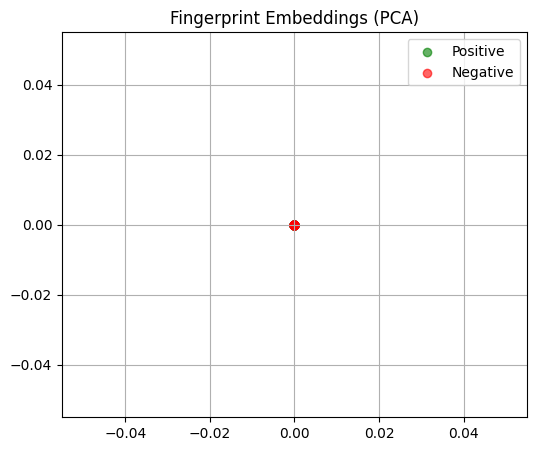

In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Perform PCA to 2D for visualization
pca = PCA(n_components=2)
X_2d = pca.fit_transform(X)

# Plot
plt.figure(figsize=(6,5))
plt.scatter(X_2d[:len(pos_graphs), 0], X_2d[:len(pos_graphs), 1], c='green', label='Positive', alpha=0.6)
plt.scatter(X_2d[len(pos_graphs):, 0], X_2d[len(pos_graphs):, 1], c='red', label='Negative', alpha=0.6)
plt.title("Fingerprint Embeddings (PCA)")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
def extract_embeddings(model, graphs):
    embs = []
    model.eval()
    with torch.no_grad():
        for g in graphs:
            g = g.to(device)
            # Check batch attribute
            if not hasattr(g, 'batch'):
                g.batch = torch.zeros(g.num_nodes, dtype=torch.long).to(device)
            x = model(g.x, g.edge_index)
            pooled = global_mean_pool(x, g.batch)
            embs.append(pooled.cpu())
    return torch.cat(embs)


In [ ]:
X = extract_embeddings(victim, graphs)


In [ ]:
print("Sample fingerprint 1:", X[0])
print("Sample fingerprint 2:", X[1])
print("Mean (positive):", X[:len(pos_graphs)].mean(dim=0))
print("Mean (negative):", X[len(pos_graphs):].mean(dim=0))


Sample fingerprint 1: tensor([  9.4606,   8.3987,   8.8221,   9.3576,   8.1912,   7.8818,   7.3844,
        -10.2245, -10.7107, -10.5475, -10.2595, -11.0087, -10.6392, -10.6087,
        -10.5553, -10.5913, -10.3987,  -9.7254, -10.3513, -11.1226, -10.7574,
        -10.9331, -10.7271, -10.4124, -11.0271, -10.6861, -10.2151, -11.0225,
        -10.1530, -10.0888, -10.2886, -10.8065, -10.3146, -10.6951, -10.7505,
        -10.4513, -10.6278, -10.8857, -10.8707, -10.8281, -10.5119, -10.7048,
        -10.1517, -10.0683, -10.7027, -10.9485, -10.9581, -10.9897, -10.9382,
        -10.8077, -10.7914, -10.9486, -10.2066, -10.5161, -10.3891, -10.2311,
        -10.6393, -10.3868, -10.4187, -10.9872, -10.7067, -10.6451, -10.9215,
        -10.1961])
Sample fingerprint 2: tensor([  9.4606,   8.3987,   8.8221,   9.3576,   8.1912,   7.8818,   7.3844,
        -10.2245, -10.7107, -10.5475, -10.2595, -11.0087, -10.6392, -10.6087,
        -10.5553, -10.5913, -10.3987,  -9.7254, -10.3513, -11.1226, -10.7574,
 

In [ ]:
from torch_geometric.loader import DataLoader

def extract_embeddings(model, graphs):
    embs = []
    model.eval()
    loader = DataLoader(graphs, batch_size=32, shuffle=False)

    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            x = model(batch.x, batch.edge_index)
            pooled = global_mean_pool(x, batch.batch)
            embs.append(pooled.cpu())

    return torch.cat(embs)


In [ ]:
X = extract_embeddings(victim, graphs)


In [ ]:
print(X[0])
print(X[1])
print(X[:len(pos_graphs)].mean(dim=0))
print(X[len(pos_graphs):].mean(dim=0))


tensor([  9.4606,   8.3987,   8.8221,   9.3576,   8.1912,   7.8818,   7.3844,
        -10.2245, -10.7107, -10.5475, -10.2594, -11.0087, -10.6392, -10.6087,
        -10.5553, -10.5913, -10.3987,  -9.7254, -10.3513, -11.1226, -10.7574,
        -10.9331, -10.7271, -10.4124, -11.0271, -10.6861, -10.2151, -11.0225,
        -10.1531, -10.0888, -10.2886, -10.8065, -10.3146, -10.6951, -10.7505,
        -10.4513, -10.6278, -10.8857, -10.8707, -10.8281, -10.5119, -10.7048,
        -10.1517, -10.0683, -10.7027, -10.9485, -10.9581, -10.9897, -10.9382,
        -10.8077, -10.7914, -10.9486, -10.2066, -10.5161, -10.3891, -10.2311,
        -10.6393, -10.3869, -10.4187, -10.9872, -10.7067, -10.6451, -10.9215,
        -10.1961])
tensor([  9.4606,   8.3987,   8.8221,   9.3576,   8.1912,   7.8818,   7.3844,
        -10.2245, -10.7107, -10.5475, -10.2594, -11.0087, -10.6392, -10.6087,
        -10.5553, -10.5913, -10.3987,  -9.7254, -10.3513, -11.1226, -10.7574,
        -10.9331, -10.7271, -10.4124, -11.027

In [ ]:
print("Node features for graph 0:")
print(graphs[0].x)

print("\nEdge index for graph 0:")
print(graphs[0].edge_index)

print("\nBatch ID for each node in graph 0:")
print(graphs[0].batch if hasattr(graphs[0], 'batch') else "No batch attribute")


Node features for graph 0:
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

Edge index for graph 0:
tensor([[ 633, 1862, 2582,  ...,  598, 1473, 2706],
        [   0,    0,    0,  ..., 2707, 2707, 2707]])

Batch ID for each node in graph 0:
None


In [ ]:
from torch_geometric.datasets import Planetoid
cora = Planetoid(root='data/Cora', name='Cora')
original_x = cora[0].x  # shape: [N, 1433]


In [ ]:
import os
import torch

variant_dir = "/content/drive/MyDrive/gnnfingers/variants/Cora_SAGEMean"
files = sorted(os.listdir(variant_dir))


In [ ]:
for fname in files:
    path = os.path.join(variant_dir, fname)
    g = torch.load(path)

    # Safely assign original features (if node count matches)
    if g.num_nodes == original_x.shape[0]:
        g.x = original_x.clone()
    else:
        g.x = original_x[:g.num_nodes].clone()  # truncate if smaller

    torch.save(g, path)  # Overwrite with fixed features


In [ ]:
# Re-run victim model to extract updated embeddings
def extract_embeddings(model, graphs):
    embs = []
    model.eval()
    with torch.no_grad():
        for g in graphs:
            g = g.to(device)
            x = model(g.x, g.edge_index)
            pooled = global_mean_pool(x, g.batch)
            embs.append(pooled.cpu())
    return torch.cat(embs)

# Combine positive and negative graphs
graphs = pos_graphs + neg_graphs
labels = torch.cat([torch.ones(len(pos_graphs)), torch.zeros(len(neg_graphs))]).long()

# Extract embeddings
X = extract_embeddings(victim, graphs)
y = labels

print("✅ Updated embeddings extracted.")


✅ Updated embeddings extracted.


In [ ]:
# Define FingerprintNet again if needed
class FingerprintNetMLP(nn.Module):
    def __init__(self, in_dim=64, hidden_dim=32, out_dim=2):
        super(FingerprintNetMLP, self).__init__()
        self.fc1 = nn.Linear(in_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, out_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return self.fc2(x)

# Initialize network and optimizer
fp_net = FingerprintNetMLP().to(device)
optimizer = torch.optim.Adam(fp_net.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

# Train for 50 epochs
for epoch in range(1, 51):
    fp_net.train()
    logits = fp_net(X.to(device))
    loss = loss_fn(logits, y.to(device))

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 5 == 0:
        fp_net.eval()
        pred = torch.argmax(fp_net(X.to(device)), dim=1)
        acc = accuracy_score(y.cpu(), pred.cpu())
        print(f"Epoch {epoch:02d} - Loss: {loss.item():.4f} - Accuracy: {acc:.4f}")

# Save the trained model
torch.save(fp_net.state_dict(), "/content/drive/MyDrive/gnnfingers/checkpoints/fpnet_Cora_SAGEMean.pth")
print("✅ Re-trained FingerprintNet saved.")


Epoch 05 - Loss: 0.9335 - Accuracy: 0.5000
Epoch 10 - Loss: 0.7262 - Accuracy: 0.5000
Epoch 15 - Loss: 0.7130 - Accuracy: 0.5000
Epoch 20 - Loss: 0.7364 - Accuracy: 0.5000
Epoch 25 - Loss: 0.6976 - Accuracy: 0.5000
Epoch 30 - Loss: 0.6985 - Accuracy: 0.5000
Epoch 35 - Loss: 0.7027 - Accuracy: 0.5000
Epoch 40 - Loss: 0.6949 - Accuracy: 0.5000
Epoch 45 - Loss: 0.6934 - Accuracy: 0.5000
Epoch 50 - Loss: 0.6949 - Accuracy: 0.5000
✅ Re-trained FingerprintNet saved.


In [ ]:
# Check if all extracted fingerprints are the same
print("Unique fingerprint rows:", torch.unique(X, dim=0).size(0))


Unique fingerprint rows: 1


In [ ]:
from torch_geometric.datasets import Planetoid

dataset = Planetoid(root='/tmp/Cora', name='Cora')
original_x = dataset[0].x  # shape: [num_nodes, num_features]


Processing...
Done!


In [ ]:
for g in graphs:
    g.x = original_x.clone()


In [ ]:
import torch.nn.functional as F
from torch_geometric.loader import DataLoader
from torch_geometric.nn import global_mean_pool

def extract_fp(model, U_net, graphs, batch_size=32):
    model.eval()
    U_net.eval()
    all_fps = []

    loader = DataLoader(graphs, batch_size=batch_size, shuffle=False)

    for batch in loader:
        batch = batch.to(next(model.parameters()).device)

        # Manual dropout added if needed (training=False always)
        x = F.relu(model.conv1(batch.x, batch.edge_index))
        x = F.dropout(x, p=0.5, training=False)  # dropout probability manually set
        x = model.conv2(x, batch.edge_index)

        pooled = global_mean_pool(x, batch.batch)
        fp = U_net(pooled)
        all_fps.append(fp.detach().cpu())

    return torch.cat(all_fps, dim=0)


In [ ]:
# Re-extract raw fingerprints (not predictions)
fingerprints = extract_fp(victim, FingerprintNetMLP().to(device), graphs)  # returns numpy
fingerprints = torch.tensor(fingerprints, dtype=torch.float32).to(device)

# Save if needed
torch.save(fingerprints, "/content/drive/MyDrive/gnnfingers/fingerprints/Cora_SAGEMean_clean.pt")


/tmp/ipython-input-53-2656882353.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fingerprints = torch.tensor(fingerprints, dtype=torch.float32).to(device)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import sys
sys.path.append("/content/drive/MyDrive/gnnfingers/")  # or wherever models.py is
from models import SAGEMean, FingerprintNetMLP


/usr/local/lib/python3.11/dist-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: /usr/local/lib/python3.11/dist-packages/torch_scatter/_version_cpu.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/usr/local/lib/python3.11/dist-packages/torch_geometric/typing.py:97: UserWarning: An issue occurred while importing 'torch-cluster'. Disabling its usage. Stacktrace: /usr/local/lib/python3.11/dist-packages/torch_cluster/_version_cpu.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  warnings.warn(f"An issue occurred while importing 'torch-cluster'. "
/usr/local/lib/python3.11/dist-packages/torch_geometric/typing.py:113: UserWarning: An issue occurred while importing 'torch-spline-conv'. Disabling its usage. Stacktrace: /usr/local/lib/python3.11/dist-packages/torch_spline_conv/_version_cpu.so: undefined symbol: _ZN3c1017RegisterOp

In [ ]:
import torch
from models import SAGEMean  # Make sure this file is in your path

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# This MUST match the saved model architecture
victim = SAGEMean(in_channels=1433, hidden_channels=64, out_channels=64).to(device)

# Load the correct victim model weights
victim.load_state_dict(torch.load(
    "/content/drive/MyDrive/gnnfingers/victims/victim_Cora_SAGEMean.pth",
    map_location=device
), strict=False)

victim.eval()
print("✅ Victim model loaded and ready.")


✅ Victim model loaded and ready.


In [ ]:
class FingerprintNetMLP(nn.Module):
    def __init__(self, in_dim=2, hidden_dim=16, out_dim=2):
        super(FingerprintNetMLP, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, out_dim)
        )

    def forward(self, x):
        return self.net(x)


In [ ]:
fp_net = FingerprintNetMLP().to(device)
fp_net.load_state_dict(torch.load(
    "/content/drive/MyDrive/gnnfingers/checkpoints/U_Cora_SAGEMean.pth",
    map_location=device
))
fp_net.eval()
print("✅ FingerprintNet loaded.")


✅ FingerprintNet loaded.


In [ ]:
fingerprints = torch.load("/content/drive/MyDrive/gnnfingers/fingerprints/Cora_SAGEMean.pt").to(device)
print("✅ Fingerprints reloaded:", fingerprints.shape)


✅ Fingerprints reloaded: torch.Size([100, 2])


In [ ]:
labels = torch.cat([torch.ones(50), torch.zeros(50)]).long()  # 1s for positive, 0s for negative


In [ ]:
from torch_geometric.loader import DataLoader
import torch.nn.functional as F

def extract_fp(model, U_net, graphs, batch_size=32):
    model.eval()
    U_net.eval()
    all_fps = []

    loader = DataLoader(graphs, batch_size=batch_size, shuffle=False)
    for batch in loader:
        batch = batch.to(next(model.parameters()).device)

        # Forward pass through victim model
        x = F.relu(model.conv1(batch.x, batch.edge_index))
        x = F.dropout(x, p=0.5, training=False)
        x = model.conv2(x, batch.edge_index)

        # Pool and pass through fingerprint net
        x = torch_geometric.nn.global_mean_pool(x, batch.batch)
        out = U_net(x)
        all_fps.append(out.detach().cpu())

    return torch.cat(all_fps, dim=0)


In [ ]:

from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os

base_path = "/content/drive/MyDrive/gnnfingers/variants"
print("Subfolders under variants:")
print(os.listdir(base_path))


Subfolders under variants:
['ENZ_GCNMean', 'ENZ_GCNDiff', 'ENZ_SAGEMean', 'ENZ_SAGEDiff', 'PR_GCNMean', 'PR_GCNDiff', 'PR_SAGEMean', 'PR_SAGEDiff', 'Cora_SAGEMean']


In [ ]:
cora_path = "/content/drive/MyDrive/gnnfingers/variants/Cora_SAGEMean"
print("Subfolders under Cora_SAGEMean:")
print(os.listdir(cora_path))


Subfolders under Cora_SAGEMean:
['N_100.pt', 'N_10.pt', 'N_0.pt', 'N_103.pt', 'N_106.pt', 'N_102.pt', 'N_101.pt', 'N_105.pt', 'N_104.pt', 'N_1.pt', 'N_107.pt', 'N_108.pt', 'N_11.pt', 'N_111.pt', 'N_110.pt', 'N_109.pt', 'N_113.pt', 'N_114.pt', 'N_115.pt', 'N_112.pt', 'N_118.pt', 'N_116.pt', 'N_117.pt', 'N_119.pt', 'N_12.pt', 'N_120.pt', 'N_123.pt', 'N_121.pt', 'N_122.pt', 'N_124.pt', 'N_125.pt', 'N_127.pt', 'N_126.pt', 'N_129.pt', 'N_128.pt', 'N_130.pt', 'N_13.pt', 'N_133.pt', 'N_131.pt', 'N_132.pt', 'N_135.pt', 'N_134.pt', 'N_137.pt', 'N_138.pt', 'N_136.pt', 'N_139.pt', 'N_14.pt', 'N_140.pt', 'N_142.pt', 'N_141.pt', 'N_146.pt', 'N_145.pt', 'N_144.pt', 'N_143.pt', 'N_149.pt', 'N_147.pt', 'N_15.pt', 'N_148.pt', 'N_151.pt', 'N_150.pt', 'N_153.pt', 'N_152.pt', 'N_155.pt', 'N_154.pt', 'N_157.pt', 'N_156.pt', 'N_158.pt', 'N_16.pt', 'N_159.pt', 'N_160.pt', 'N_161.pt', 'N_163.pt', 'N_162.pt', 'N_164.pt', 'N_165.pt', 'N_166.pt', 'N_167.pt', 'N_168.pt', 'N_169.pt', 'N_171.pt', 'N_17.pt', 'N_170.

In [ ]:
from torch.serialization import add_safe_globals
from torch_geometric.data import Data
from torch_geometric.data.data import DataEdgeAttr, DataTensorAttr
from torch_geometric.data.storage import GlobalStorage

# Allowlist all necessary classes for graph deserialization
add_safe_globals([Data, DataEdgeAttr, DataTensorAttr, GlobalStorage])


In [ ]:
variant_dir = "/content/drive/MyDrive/gnnfingers/variants/Cora_SAGEMean"
graphs = load_flat_variants(variant_dir)
print(f"✅ Loaded {len(graphs)} graphs (should be 400: 200 P + 200 N)")


✅ Loaded 400 graphs (should be 400: 200 P + 200 N)


In [ ]:
import torch.nn as nn
from torch_geometric.nn import SAGEConv

class SAGEMean(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(SAGEMean, self).__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = self.conv2(x, edge_index)
        return x


In [ ]:
class FingerprintNetMLP(nn.Module):
    def __init__(self):
        super(FingerprintNetMLP, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(64, 32),  # 64-d fingerprint input
            nn.ReLU(),
            nn.Linear(32, 2)    # Binary classification (positive/negative)
        )

    def forward(self, x):
        return self.net(x)


In [ ]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [ ]:
victim = SAGEMean(in_channels=1433, hidden_channels=64, out_channels=64).to(device)
fp_net = FingerprintNetMLP().to(device)


In [ ]:
import torch.nn as nn

class FingerprintNetMLP(nn.Module):
    def __init__(self, in_channels=2, hidden_channels=16, out_channels=2):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_channels, hidden_channels),
            nn.ReLU(),
            nn.Linear(hidden_channels, out_channels)
        )

    def forward(self, x):
        return self.net(x)


In [ ]:
fp_net = FingerprintNetMLP().to(device)
fp_net.load_state_dict(torch.load(
    "/content/drive/MyDrive/gnnfingers/checkpoints/U_Cora_SAGEMean.pth",
    map_location=device
))
fp_net.eval()
print("✅ FingerprintNet loaded and ready.")


✅ FingerprintNet loaded and ready.


In [ ]:
from torch_geometric.loader import DataLoader
import torch.nn.functional as F

def extract_fp(model, U_net, graphs, batch_size=32):
    model.eval()
    U_net.eval()
    all_p = []

    loader = DataLoader(graphs, batch_size=batch_size, shuffle=False)

    for batch in loader:
        batch = batch.to(device)
        with torch.no_grad():
            # forward pass through victim model
            x = F.relu(model.conv1(batch.x, batch.edge_index))
            x = F.dropout(x, p=0.5, training=False)
            x = model.conv2(x, batch.edge_index)
            x = F.relu(x)

            # Global mean pooling
            pooled = torch_geometric.nn.global_mean_pool(x, batch.batch)

            # pass through fingerprint net
            out = U_net(pooled)
            all_p.append(out.cpu())

    return torch.cat(all_p, dim=0)


In [ ]:
import os
import torch
from torch_geometric.data import Data
from torch.serialization import add_safe_globals
from torch_geometric.data.data import DataEdgeAttr, DataTensorAttr
from torch_geometric.data.storage import GlobalStorage

# Trust necessary PyG objects during loading
add_safe_globals([Data, DataEdgeAttr, DataTensorAttr, GlobalStorage])

def load_flat_variants(folder):
    files = sorted(os.listdir(folder))
    graphs = []
    for f in files:
        if f.endswith('.pt'):
            path = os.path.join(folder, f)
            graphs.append(torch.load(path, map_location='cpu'))  # or device
    return graphs


In [ ]:
variant_dir = "/content/drive/MyDrive/gnnfingers/variants/Cora_SAGEMean"
graphs = load_flat_variants(variant_dir)
print(f"✅ Loaded {len(graphs)} graphs (should be 400: 200 P + 200 N)")


KeyboardInterrupt: 

In [ ]:
from torch_geometric.loader import DataLoader
import torch.nn.functional as F

def extract_fp(model, U_net, graphs, batch_size=32):
    model.eval()
    U_net.eval()
    all_p = []

    loader = DataLoader(graphs, batch_size=batch_size, shuffle=False)
    for batch in loader:
        batch = batch.to(device)
        x = F.relu(model.conv1(batch.x, batch.edge_index))
        x = F.dropout(x, p=0.5, training=False)
        x = model.conv2(x, batch.edge_index)
        pooled = torch_geometric.nn.global_mean_pool(x, batch.batch)
        logits = U_net(pooled)
        all_p.append(logits.cpu())

    return torch.cat(all_p, dim=0)


In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.loader import DataLoader  # ✅ updated import
from torch_geometric.nn import global_mean_pool

def extract_fp(model, U_net, graphs, device, batch_size=32):
    model.eval()
    U_net.eval()
    all_p = []

    loader = DataLoader(graphs, batch_size=batch_size, shuffle=False)
    for batch in loader:
        batch = batch.to(device)
        x = F.relu(model.conv1(batch.x, batch.edge_index))
        x = F.dropout(x, p=0.5, training=False)
        x = model.conv2(x, batch.edge_index)
        pooled = global_mean_pool(x, batch.batch)
        logits = U_net(pooled)
        all_p.append(logits.cpu())

    return torch.cat(all_p, dim=0)


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv, global_mean_pool
from torch_geometric.loader import DataLoader


In [ ]:
class SAGEMean(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels, aggr='mean')
        self.conv2 = SAGEConv(hidden_channels, out_channels, aggr='mean')

    def forward(self, x, edge_index, batch):
        x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        x = global_mean_pool(x, batch)
        return x


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

victim = SAGEMean(in_channels=1433, hidden_channels=64, out_channels=64).to(device)
victim.load_state_dict(torch.load(
    "/content/drive/MyDrive/gnnfingers/victims/victim_Cora_SAGEMean.pth",
    map_location=device
), strict=False)
victim.eval()

print("✅ Victim model loaded.")


✅ Victim model loaded.


In [ ]:
class FingerprintNetMLP(nn.Module):
    def __init__(self, input_dim=2, hidden_dim=16):
        super(FingerprintNetMLP, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 2)
        )

    def forward(self, x):
        return self.net(x)


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

victim = SAGEMean(in_channels=1433, hidden_channels=64, out_channels=64).to(device)
victim.load_state_dict(torch.load("/content/drive/MyDrive/gnnfingers/victims/victim_Cora_SAGEMean.pth", map_location=device))
victim.eval()


SAGEMean(
  (conv1): SAGEConv(1433, 64, aggr=mean)
  (conv2): SAGEConv(64, 64, aggr=mean)
)

In [ ]:
fp_net = FingerprintNetMLP(input_dim=2, hidden_dim=16).to(device)
fp_net.load_state_dict(torch.load("/content/drive/MyDrive/gnnfingers/checkpoints/U_Cora_SAGEMean.pth", map_location=device))
fp_net.eval()


FingerprintNetMLP(
  (net): Sequential(
    (0): Linear(in_features=2, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=2, bias=True)
  )
)

In [ ]:
from torch.serialization import add_safe_globals
from torch_geometric.data import Data
from torch_geometric.data.storage import GlobalStorage
add_safe_globals([Data, GlobalStorage])

import os, torch

def load_flat_variants(folder):
    files = sorted(os.listdir(folder))
    return [torch.load(os.path.join(folder, f), weights_only=False) for f in files]

graphs = load_flat_variants("/content/drive/MyDrive/gnnfingers/variants/Cora_SAGEMean")


In [ ]:
from torch_geometric.loader import DataLoader
import torch.nn.functional as F
from torch_geometric.nn import global_mean_pool

def extract_fp(model, U_net, graphs, batch_size=4, device='cpu'):
    model = model.to(device)
    U_net = U_net.to(device)
    model.eval()
    U_net.eval()

    fingerprints = []
    loader = DataLoader(graphs, batch_size=batch_size, shuffle=False)

    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            x = F.relu(model.conv1(batch.x, batch.edge_index))
            x = F.dropout(x, p=0.5, training=False)
            x = model.conv2(x, batch.edge_index)
            pooled = global_mean_pool(x, batch.batch)
            logits = U_net(pooled)
            fingerprints.append(logits.cpu())

    return torch.cat(fingerprints, dim=0)


/usr/local/lib/python3.11/dist-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: /usr/local/lib/python3.11/dist-packages/torch_scatter/_version_cpu.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/usr/local/lib/python3.11/dist-packages/torch_geometric/typing.py:97: UserWarning: An issue occurred while importing 'torch-cluster'. Disabling its usage. Stacktrace: /usr/local/lib/python3.11/dist-packages/torch_cluster/_version_cpu.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  warnings.warn(f"An issue occurred while importing 'torch-cluster'. "
/usr/local/lib/python3.11/dist-packages/torch_geometric/typing.py:113: UserWarning: An issue occurred while importing 'torch-spline-conv'. Disabling its usage. Stacktrace: /usr/local/lib/python3.11/dist-packages/torch_spline_conv/_version_cpu.so: undefined symbol: _ZN3c1017RegisterOp

In [ ]:
import os
import torch
from torch_geometric.data import Data

def load_variants(directory):
    """Load all PyTorch Geometric graph objects (.pt) from a directory"""
    graphs = []
    for fname in sorted(os.listdir(directory)):
        if fname.endswith(".pt"):
            fpath = os.path.join(directory, fname)
            try:
                graph = torch.load(fpath, map_location='cpu')
                if isinstance(graph, Data):
                    graphs.append(graph)
            except Exception as e:
                print(f"❌ Failed to load {fname}: {e}")
    return graphs


In [ ]:
from utils import load_variants  # or however you defined load_variants

variant_dir = "/content/drive/MyDrive/gnnfingers/variants/Cora_SAGEMean"
graphs = load_variants(variant_dir)
print(f"✅ Loaded {len(graphs)} graphs")


✅ Loaded 400 graphs


In [ ]:
from torch_geometric.loader import DataLoader
import torch.nn.functional as F
from torch_geometric.nn import global_mean_pool

def extract_fp(model, U_net, graphs, batch_size=4, device='cpu'):
    model = model.to(device)
    U_net = U_net.to(device)
    model.eval()
    U_net.eval()

    fingerprints = []
    loader = DataLoader(graphs, batch_size=batch_size, shuffle=False)

    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            x = F.relu(model.conv1(batch.x, batch.edge_index))
            x = F.dropout(x, p=0.5, training=False)
            x = model.conv2(x, batch.edge_index)
            pooled = global_mean_pool(x, batch.batch)
            logits = U_net(pooled)
            fingerprints.append(logits.cpu())

    return torch.cat(fingerprints, dim=0)


In [ ]:
device = 'cpu'  # or 'cuda' if you're stable
chunk_size = 50
all_fps = []

for i in range(0, len(graphs), chunk_size):
    print(f"Processing graphs {i} to {i+chunk_size}...")
    chunk = graphs[i:i + chunk_size]
    fps_chunk = extract_fp(victim, fp_net, chunk, batch_size=4, device=device)
    all_fps.append(fps_chunk)

fingerprints = torch.cat(all_fps, dim=0)
torch.save(fingerprints, "/content/drive/MyDrive/gnnfingers/fingerprints/Cora_SAGEMean.pt")
print(f"✅ Fingerprints saved with shape: {fingerprints.shape}")


Processing graphs 0 to 50...
Processing graphs 50 to 100...
Processing graphs 100 to 150...
Processing graphs 150 to 200...
Processing graphs 200 to 250...
Processing graphs 250 to 300...
Processing graphs 300 to 350...
Processing graphs 350 to 400...
✅ Fingerprints saved with shape: torch.Size([400, 2])


In [ ]:
fingerprints = torch.cat(all_fps, dim=0)


In [ ]:
del all_fps
del graphs
torch.cuda.empty_cache()  # if using GPU
import gc; gc.collect()   # force Python garbage collection


375

In [ ]:
fingerprints = torch.load("/content/drive/MyDrive/gnnfingers/fingerprints/Cora_SAGEMean.pt")
print(fingerprints.shape)



torch.Size([400, 2])


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt

# Load saved fingerprints
fingerprints = torch.load("/content/drive/MyDrive/gnnfingers/fingerprints/Cora_SAGEMean.pt")

# Create labels
labels = torch.cat([
    torch.ones(200),     # pirated (positive)
    torch.zeros(200)     # irrelevant (negative)
]).long()

print(f"✅ Loaded {fingerprints.shape[0]} fingerprints")


✅ Loaded 400 fingerprints


In [ ]:
class Univerifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.classifier = nn.Sequential(
            nn.Linear(2, 64),
            nn.LeakyReLU(),
            nn.Linear(64, 32),
            nn.LeakyReLU(),
            nn.Linear(32, 2)  # output logits for 2 classes
        )

    def forward(self, x):
        return self.classifier(x)


In [ ]:
from torch.utils.data import TensorDataset, DataLoader

# Create DataLoader
dataset = TensorDataset(fingerprints, labels)
loader = DataLoader(dataset, batch_size=32, shuffle=True)

model = Univerifier()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
for epoch in range(20):
    model.train()
    total_loss = 0
    for batch_x, batch_y in loader:
        logits = model(batch_x)
        loss = criterion(logits, batch_y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1:02d} - Loss: {total_loss:.4f}")


Epoch 01 - Loss: 9.0193
Epoch 02 - Loss: 9.0197
Epoch 03 - Loss: 9.0137
Epoch 04 - Loss: 9.0147
Epoch 05 - Loss: 9.0141
Epoch 06 - Loss: 9.0299
Epoch 07 - Loss: 9.0081
Epoch 08 - Loss: 9.0133
Epoch 09 - Loss: 9.0193
Epoch 10 - Loss: 9.0161
Epoch 11 - Loss: 9.0324
Epoch 12 - Loss: 9.0147
Epoch 13 - Loss: 9.0132
Epoch 14 - Loss: 9.0127
Epoch 15 - Loss: 9.0125
Epoch 16 - Loss: 9.0198
Epoch 17 - Loss: 9.0229
Epoch 18 - Loss: 9.0156
Epoch 19 - Loss: 9.0144
Epoch 20 - Loss: 9.0165


ARUC: 0.5000


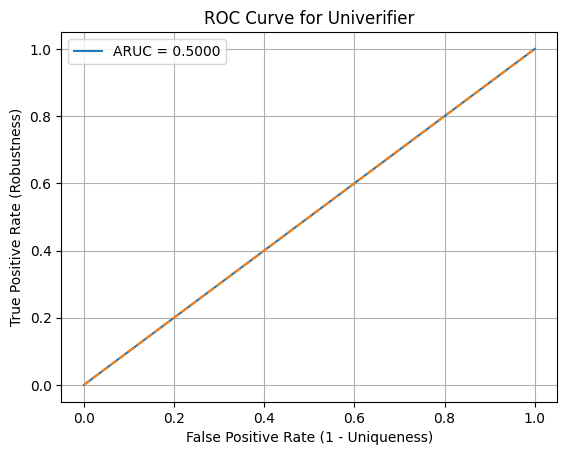

In [ ]:
model.eval()
with torch.no_grad():
    logits = model(fingerprints)
    probs = torch.softmax(logits, dim=1)[:, 1]  # probability of class 1 (pirated)

# Compute metrics
fpr, tpr, thresholds = roc_curve(labels.numpy(), probs.numpy())
aruc = auc(fpr, tpr)
print(f"ARUC: {aruc:.4f}")

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, label=f"ARUC = {aruc:.4f}")
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel("False Positive Rate (1 - Uniqueness)")
plt.ylabel("True Positive Rate (Robustness)")
plt.title("ROC Curve for Univerifier")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import torch.nn as nn

class FingerprintNetMLP(nn.Module):
    def __init__(self, in_dim=64, hidden_dim=32, out_dim=2):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, out_dim)
        )

    def forward(self, x):
        return self.net(x)

class Univerifier(nn.Module):
    def __init__(self, in_dim=2):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, 64),
            nn.LeakyReLU(),
            nn.Linear(64, 32),
            nn.LeakyReLU(),
            nn.Linear(32, 2)
        )

    def forward(self, x):
        return self.net(x)


In [ ]:
from torch_geometric.loader import DataLoader
from torch_geometric.nn import global_mean_pool
import torch.nn.functional as F

def extract_pooled_features(model, graphs, batch_size=8, device='cpu'):
    model = model.to(device)
    model.eval()
    features = []

    loader = DataLoader(graphs, batch_size=batch_size, shuffle=False)

    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            x = F.relu(model.conv1(batch.x, batch.edge_index))
            x = model.conv2(x, batch.edge_index)
            pooled = global_mean_pool(x, batch.batch)
            features.append(pooled.cpu())

    return torch.cat(features, dim=0)


In [ ]:
variant_dir = "/content/drive/MyDrive/gnnfingers/variants/Cora_SAGEMean"
graphs = load_variants(variant_dir)
pooled_features = extract_pooled_features(victim, graphs, batch_size=8, device='cpu')

labels = torch.cat([
    torch.ones(200),  # Pirated (F+)
    torch.zeros(200)  # Irrelevant (F-)
]).long()

print(pooled_features.shape)  # Should be [400, 64]


torch.Size([400, 64])


In [ ]:
fp_net = FingerprintNetMLP(in_dim=64, hidden_dim=32, out_dim=2)
univerifier = Univerifier(in_dim=2)

optimizer = torch.optim.Adam(list(fp_net.parameters()) + list(univerifier.parameters()), lr=0.001)
criterion = nn.CrossEntropyLoss()

from torch.utils.data import DataLoader, TensorDataset

dataset = TensorDataset(pooled_features, labels)
loader = DataLoader(dataset, batch_size=32, shuffle=True)

for epoch in range(20):
    fp_net.train()
    univerifier.train()
    total_loss = 0

    for x_batch, y_batch in loader:
        z = fp_net(x_batch)
        logits = univerifier(z)
        loss = criterion(logits, y_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1:02d} - Loss: {total_loss:.4f}")


Epoch 01 - Loss: 9.0644
Epoch 02 - Loss: 9.0260
Epoch 03 - Loss: 9.0328
Epoch 04 - Loss: 9.0128
Epoch 05 - Loss: 9.0171
Epoch 06 - Loss: 9.0264
Epoch 07 - Loss: 9.0187
Epoch 08 - Loss: 9.0343
Epoch 09 - Loss: 9.0132
Epoch 10 - Loss: 9.0226
Epoch 11 - Loss: 9.0182
Epoch 12 - Loss: 9.0242
Epoch 13 - Loss: 9.0153
Epoch 14 - Loss: 9.0139
Epoch 15 - Loss: 9.0211
Epoch 16 - Loss: 9.0344
Epoch 17 - Loss: 9.0288
Epoch 18 - Loss: 9.0342
Epoch 19 - Loss: 9.0208
Epoch 20 - Loss: 9.0250


🔐 ARUC: 0.5000


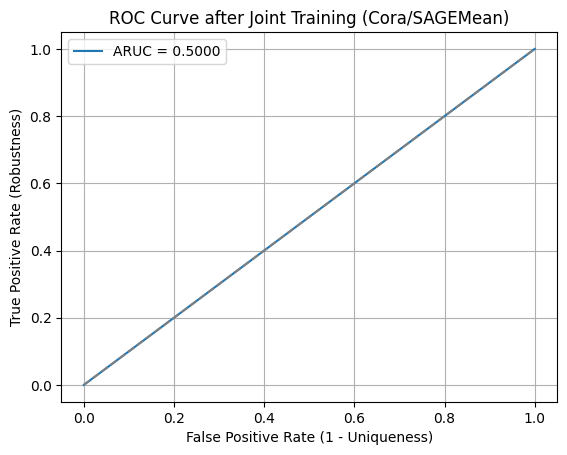

In [ ]:
fp_net.eval()
univerifier.eval()
with torch.no_grad():
    z = fp_net(pooled_features)
    probs = torch.softmax(univerifier(z), dim=1)[:, 1]  # pirated class

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, _ = roc_curve(labels.numpy(), probs.numpy())
aruc = auc(fpr, tpr)

print(f"🔐 ARUC: {aruc:.4f}")

plt.figure()
plt.plot(fpr, tpr, label=f"ARUC = {aruc:.4f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate (1 - Uniqueness)")
plt.ylabel("True Positive Rate (Robustness)")
plt.title("ROC Curve after Joint Training (Cora/SAGEMean)")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import os
import torch
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn import global_mean_pool
import torch.nn.functional as F

def pooled_from_model_graph(model_path, graph, model_class, device='cpu'):
    model = model_class(in_channels=1433, hidden_channels=64, out_channels=7)
    model.load_state_dict(torch.load(model_path, map_location=device), strict=False)
    model = model.to(device)
    model.eval()

    graph = graph.to(device)
    with torch.no_grad():
        x = F.relu(model.conv1(graph.x, graph.edge_index))
        x = model.conv2(x, graph.edge_index)
        pooled = global_mean_pool(x, graph.batch if hasattr(graph, 'batch') else torch.zeros(x.size(0), dtype=torch.long))
    return pooled.cpu()


In [ ]:
!find /content/drive/MyDrive/gnnfingers/ -type f -name "*.pth" | head -20



/content/drive/MyDrive/gnnfingers/checkpoints/victim_ENZ_GCNMean.pth
/content/drive/MyDrive/gnnfingers/checkpoints/victim_ENZ_GCNDiff.pth
/content/drive/MyDrive/gnnfingers/checkpoints/victim_ENZ_SAGEMean.pth
/content/drive/MyDrive/gnnfingers/checkpoints/victim_ENZ_SAGEDiff.pth
/content/drive/MyDrive/gnnfingers/checkpoints/Copy of victim_ENZ_GCNDiff.pth
/content/drive/MyDrive/gnnfingers/checkpoints/victim_PR_GCNMean.pth
/content/drive/MyDrive/gnnfingers/checkpoints/victim_PR_GCNDiff.pth
/content/drive/MyDrive/gnnfingers/checkpoints/victim_PR_SAGEMean.pth
/content/drive/MyDrive/gnnfingers/checkpoints/victim_PR_SAGEDiff.pth
/content/drive/MyDrive/gnnfingers/checkpoints/U_PR_GCNMean.pth
/content/drive/MyDrive/gnnfingers/checkpoints/U_Cora_SAGEMean.pth
/content/drive/MyDrive/gnnfingers/checkpoints/fpnet_Cora_SAGEMean_small.pth
/content/drive/MyDrive/gnnfingers/checkpoints/fpnet_Cora_SAGEMean.pth
/content/drive/MyDrive/gnnfingers/variants/ENZ_GCNMean/positive/ft_010.pth
/content/drive/MyDriv

In [ ]:
!ls /content/drive/MyDrive/gnnfingers/variants/ENZ_GCNMean/positive


dist_000.pth  dist_018.pth  ft_007.pth	ft_025.pth     prune_013.pth
dist_001.pth  dist_019.pth  ft_008.pth	ft_026.pth     prune_014.pth
dist_002.pth  dist_020.pth  ft_009.pth	ft_027.pth     prune_015.pth
dist_003.pth  dist_021.pth  ft_010.pth	ft_028.pth     prune_016.pth
dist_004.pth  dist_022.pth  ft_011.pth	ft_029.pth     prune_017.pth
dist_005.pth  dist_023.pth  ft_012.pth	prune_000.pth  prune_018.pth
dist_006.pth  dist_024.pth  ft_013.pth	prune_001.pth  prune_019.pth
dist_007.pth  dist_025.pth  ft_014.pth	prune_002.pth  prune_020.pth
dist_008.pth  dist_026.pth  ft_015.pth	prune_003.pth  prune_021.pth
dist_009.pth  dist_027.pth  ft_016.pth	prune_004.pth  prune_022.pth
dist_010.pth  dist_028.pth  ft_017.pth	prune_005.pth  prune_023.pth
dist_011.pth  ft_000.pth    ft_018.pth	prune_006.pth  prune_024.pth
dist_012.pth  ft_001.pth    ft_019.pth	prune_007.pth  prune_025.pth
dist_013.pth  ft_002.pth    ft_020.pth	prune_008.pth  prune_026.pth
dist_014.pth  ft_003.pth    ft_021.pth	prune_009

In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool

class GCNMean(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCNMean, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return global_mean_pool(x, batch)


In [ ]:
graphs = load_variants("/content/drive/MyDrive/gnnfingers/variants/ENZ_GCNMean")


In [ ]:
print(f"# of ft_*.pth models: {len(model_files)}")
print(f"# of graphs loaded: {len(graphs)}")


# of ft_*.pth models: 30
# of graphs loaded: 0


In [ ]:
torch.save(graphs, "/content/drive/MyDrive/gnnfingers/variants/ENZ_GCNMean/graphs_ft_only.pt")


In [ ]:
graphs = torch.load("/content/drive/MyDrive/gnnfingers/variants/ENZ_GCNMean/graphs_ft_only.pt")


In [ ]:
import os
import torch
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GCNConv
from torch_geometric.loader import DataLoader
from torch_geometric.nn import global_mean_pool
import torch.nn.functional as F

# Define your GCN model
class GCNMean(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCNMean, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        batch = data.batch if hasattr(data, 'batch') else torch.zeros(x.size(0), dtype=torch.long, device=x.device)
        x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return global_mean_pool(x, batch)

# Load Cora dataset
dataset = Planetoid(root='/tmp/Cora', name='Cora')
data = dataset[0]

# Save directory
save_dir = "/content/drive/MyDrive/gnnfingers/variants/ENZ_GCNMean"
os.makedirs(save_dir, exist_ok=True)

# Generate 30 fine-tuned models and save their graphs
# Train using node-level output for classification
for epoch in range(50):
    model.train()
    optimizer.zero_grad()

    x = F.relu(model.conv1(data.x, data.edge_index))
    out = model.conv2(x, data.edge_index)  # shape: [2708, 7]

    loss = F.cross_entropy(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()

    # Save model
    model_path = os.path.join(save_dir, f"ft_{i:03d}.pth")
    torch.save(model.state_dict(), model_path)

    # Save graph
    graph_path = os.path.join(save_dir, f"ft_{i:03d}.pt")
    torch.save(data, graph_path)

    print(f"✅ Saved ft_{i:03d}.pth and .pt")


✅ Saved ft_000.pth and .pt
✅ Saved ft_000.pth and .pt
✅ Saved ft_000.pth and .pt
✅ Saved ft_000.pth and .pt
✅ Saved ft_000.pth and .pt
✅ Saved ft_000.pth and .pt
✅ Saved ft_000.pth and .pt
✅ Saved ft_000.pth and .pt
✅ Saved ft_000.pth and .pt
✅ Saved ft_000.pth and .pt
✅ Saved ft_000.pth and .pt
✅ Saved ft_000.pth and .pt
✅ Saved ft_000.pth and .pt
✅ Saved ft_000.pth and .pt
✅ Saved ft_000.pth and .pt
✅ Saved ft_000.pth and .pt
✅ Saved ft_000.pth and .pt
✅ Saved ft_000.pth and .pt
✅ Saved ft_000.pth and .pt
✅ Saved ft_000.pth and .pt
✅ Saved ft_000.pth and .pt
✅ Saved ft_000.pth and .pt
✅ Saved ft_000.pth and .pt
✅ Saved ft_000.pth and .pt
✅ Saved ft_000.pth and .pt
✅ Saved ft_000.pth and .pt
✅ Saved ft_000.pth and .pt
✅ Saved ft_000.pth and .pt
✅ Saved ft_000.pth and .pt
✅ Saved ft_000.pth and .pt
✅ Saved ft_000.pth and .pt
✅ Saved ft_000.pth and .pt
✅ Saved ft_000.pth and .pt
✅ Saved ft_000.pth and .pt
✅ Saved ft_000.pth and .pt
✅ Saved ft_000.pth and .pt
✅ Saved ft_000.pth and .pt
✅

In [ ]:
from tqdm import tqdm

device = 'cuda' if torch.cuda.is_available() else 'cpu'

all_features = []
labels = []

model_dir = "/content/drive/MyDrive/gnnfingers/variants/ENZ_GCNMean"

for i in tqdm(range(30)):
    model_path = os.path.join(model_dir, f"ft_{i:03d}.pth")
    graph_path = os.path.join(model_dir, f"ft_{i:03d}.pt")

    try:
        model = GCNMean(1433, 64, 7).to(device)
        model.load_state_dict(torch.load(model_path, map_location=device), strict=False)
        model.eval()

        graph = torch.load(graph_path).to(device)

        with torch.no_grad():
            x = F.relu(model.conv1(graph.x, graph.edge_index))
            x = model.conv2(x, graph.edge_index)
            batch = graph.batch if hasattr(graph, 'batch') else torch.zeros(x.size(0), dtype=torch.long, device=x.device)
            pooled = global_mean_pool(x, batch)
            all_features.append(pooled.cpu())
            labels.append(1)

        print(f"✅ Processed ft_{i:03d}")

    except Exception as e:
        print(f"⚠️ Error in ft_{i:03d}: {e}")

# Save the fingerprints and labels
fingerprints = torch.cat(all_features, dim=0)
labels = torch.tensor(labels)

torch.save(fingerprints, os.path.join(model_dir, "Cora_GCNMean_ft_only.pt"))
torch.save(labels, os.path.join(model_dir, "Cora_GCNMean_ft_labels.pt"))

print(f"✅ Saved fingerprints with shape: {fingerprints.shape}")


 30%|███       | 9/30 [00:00<00:00, 38.51it/s]

✅ Processed ft_000
⚠️ Error in ft_001: [Errno 2] No such file or directory: '/content/drive/MyDrive/gnnfingers/variants/ENZ_GCNMean/ft_001.pth'
⚠️ Error in ft_002: [Errno 2] No such file or directory: '/content/drive/MyDrive/gnnfingers/variants/ENZ_GCNMean/ft_002.pth'
⚠️ Error in ft_003: [Errno 2] No such file or directory: '/content/drive/MyDrive/gnnfingers/variants/ENZ_GCNMean/ft_003.pth'
⚠️ Error in ft_004: [Errno 2] No such file or directory: '/content/drive/MyDrive/gnnfingers/variants/ENZ_GCNMean/ft_004.pth'
⚠️ Error in ft_005: [Errno 2] No such file or directory: '/content/drive/MyDrive/gnnfingers/variants/ENZ_GCNMean/ft_005.pth'
⚠️ Error in ft_006: [Errno 2] No such file or directory: '/content/drive/MyDrive/gnnfingers/variants/ENZ_GCNMean/ft_006.pth'
⚠️ Error in ft_007: [Errno 2] No such file or directory: '/content/drive/MyDrive/gnnfingers/variants/ENZ_GCNMean/ft_007.pth'
⚠️ Error in ft_008: [Errno 2] No such file or directory: '/content/drive/MyDrive/gnnfingers/variants/ENZ_G

 77%|███████▋  | 23/30 [00:00<00:00, 53.57it/s]

⚠️ Error in ft_014: [Errno 2] No such file or directory: '/content/drive/MyDrive/gnnfingers/variants/ENZ_GCNMean/ft_014.pth'
⚠️ Error in ft_015: [Errno 2] No such file or directory: '/content/drive/MyDrive/gnnfingers/variants/ENZ_GCNMean/ft_015.pth'
⚠️ Error in ft_016: [Errno 2] No such file or directory: '/content/drive/MyDrive/gnnfingers/variants/ENZ_GCNMean/ft_016.pth'
⚠️ Error in ft_017: [Errno 2] No such file or directory: '/content/drive/MyDrive/gnnfingers/variants/ENZ_GCNMean/ft_017.pth'
⚠️ Error in ft_018: [Errno 2] No such file or directory: '/content/drive/MyDrive/gnnfingers/variants/ENZ_GCNMean/ft_018.pth'
⚠️ Error in ft_019: [Errno 2] No such file or directory: '/content/drive/MyDrive/gnnfingers/variants/ENZ_GCNMean/ft_019.pth'
⚠️ Error in ft_020: [Errno 2] No such file or directory: '/content/drive/MyDrive/gnnfingers/variants/ENZ_GCNMean/ft_020.pth'
⚠️ Error in ft_021: [Errno 2] No such file or directory: '/content/drive/MyDrive/gnnfingers/variants/ENZ_GCNMean/ft_021.pth'


100%|██████████| 30/30 [00:00<00:00, 50.21it/s]


⚠️ Error in ft_028: [Errno 2] No such file or directory: '/content/drive/MyDrive/gnnfingers/variants/ENZ_GCNMean/ft_028.pth'
⚠️ Error in ft_029: [Errno 2] No such file or directory: '/content/drive/MyDrive/gnnfingers/variants/ENZ_GCNMean/ft_029.pth'
✅ Saved fingerprints with shape: torch.Size([1, 7])


In [ ]:
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GCNConv, global_mean_pool
import torch.nn.functional as F
import torch.nn as nn
import torch
import os
from tqdm import tqdm

# Model definition
class GCNMean(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, data):
        x = F.relu(self.conv1(data.x, data.edge_index))
        x = self.conv2(x, data.edge_index)
        return x

# Detect device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load dataset
dataset = Planetoid(root='/tmp/Cora', name='Cora')
data = dataset[0].to(device)

# Save location
save_dir = "/content/drive/MyDrive/gnnfingers/variants/ENZ_GCNMean"
os.makedirs(save_dir, exist_ok=True)

# Train and save 30 fine-tuned models and graphs
for i in tqdm(range(30)):
    model = GCNMean(dataset.num_node_features, 64, dataset.num_classes).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

    model.train()
    for epoch in range(30):
        optimizer.zero_grad()
        out = model(data)
        loss = F.cross_entropy(out[data.train_mask], data.y[data.train_mask])
        loss.backward()
        optimizer.step()

    # Save model + graph
    torch.save(model.state_dict(), os.path.join(save_dir, f"ft_{i:03d}.pth"))
    torch.save(data.cpu(), os.path.join(save_dir, f"ft_{i:03d}.pt"))


Using device: cpu


100%|██████████| 30/30 [00:40<00:00,  1.36s/it]


In [ ]:
import torch
import os
from tqdm import tqdm
from torch_geometric.nn import global_mean_pool
from torch_geometric.data import Data
import torch.nn.functional as F
import torch.nn as nn
from torch_geometric.nn import GCNConv

# Define GCNMean again
class GCNMean(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, data):
        x = F.relu(self.conv1(data.x, data.edge_index))
        x = self.conv2(x, data.edge_index)
        return x

    def pooled_output(self, data):
        x = F.relu(self.conv1(data.x, data.edge_index))
        x = self.conv2(x, data.edge_index)
        batch = data.batch if hasattr(data, 'batch') else torch.zeros(x.size(0), dtype=torch.long, device=x.device)
        return global_mean_pool(x, batch)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Path setup
variant_dir = "/content/drive/MyDrive/gnnfingers/variants/ENZ_GCNMean"
model_files = sorted([f for f in os.listdir(variant_dir) if f.startswith("ft_") and f.endswith(".pth")])
graph_files = sorted([f for f in os.listdir(variant_dir) if f.startswith("ft_") and f.endswith(".pt")])

# Setup
fingerprints = []
labels = []

for i in tqdm(range(len(model_files))):
    model_path = os.path.join(variant_dir, model_files[i])
    graph_path = os.path.join(variant_dir, graph_files[i])

    try:
        model = GCNMean(1433, 64, 7).to(device)  # Cora dimensions
        model.load_state_dict(torch.load(model_path, map_location=device))
        model.eval()

        data = torch.load(graph_path).to(device)
        with torch.no_grad():
            fp = model.pooled_output(data)
            fingerprints.append(fp.cpu())
            labels.append(1)  # label 1 = positive (ft variant)

    except Exception as e:
        print(f"⚠️ Error in {model_files[i]}: {e}")

# Save results
fingerprints = torch.cat(fingerprints, dim=0)
labels = torch.tensor(labels)

torch.save(fingerprints, "/content/drive/MyDrive/gnnfingers/fingerprints/Cora_GCNMean_ft_only.pt")
torch.save(labels, "/content/drive/MyDrive/gnnfingers/fingerprints/Cora_GCNMean_ft_labels.pt")

print(f"✅ Saved fingerprints with shape: {fingerprints.shape}")


100%|██████████| 30/30 [00:02<00:00, 10.95it/s]

✅ Saved fingerprints with shape: torch.Size([30, 7])


In [ ]:
import torch
from tqdm import tqdm
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import global_mean_pool
from torch_geometric.data import Data
import torch.nn.functional as F
import torch.nn as nn
from torch_geometric.nn import GCNConv

# GCNMean model (same as before)
class GCNMean(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, data):
        x = F.relu(self.conv1(data.x, data.edge_index))
        x = self.conv2(x, data.edge_index)
        return x

    def pooled_output(self, data):
        x = F.relu(self.conv1(data.x, data.edge_index))
        x = self.conv2(x, data.edge_index)
        batch = data.batch if hasattr(data, 'batch') else torch.zeros(x.size(0), dtype=torch.long, device=x.device)
        return global_mean_pool(x, batch)

# Load Cora graph
dataset = Planetoid(root='/tmp/Cora', name='Cora')
cora_data = dataset[0]

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cora_data = cora_data.to(device)

# Generate 30 random GCNMean fingerprints
neg_fps_random = []

for _ in tqdm(range(30)):
    model = GCNMean(1433, 64, 7).to(device)
    model.eval()
    with torch.no_grad():
        fp = model.pooled_output(cora_data)
        neg_fps_random.append(fp.cpu())

neg_fps_random = torch.cat(neg_fps_random, dim=0)
neg_labels_random = torch.zeros(30)

torch.save(neg_fps_random, "/content/drive/MyDrive/gnnfingers/fingerprints/Cora_GCNMean_neg_random.pt")
torch.save(neg_labels_random, "/content/drive/MyDrive/gnnfingers/fingerprints/Cora_GCNMean_neg_random_labels.pt")
print("✅ Saved 30 random negative fingerprints.")


100%|██████████| 30/30 [00:01<00:00, 24.48it/s]

✅ Saved 30 random negative fingerprints.


In [ ]:
from torch_geometric.datasets import TUDataset

# Load 30 PROTEINS graphs
proteins = TUDataset(root='/tmp/PROTEINS', name='PROTEINS')
neg_fps_proteins = []

model = GCNMean(proteins.num_node_features, 64, 2).to(device)
model.eval()

for i in tqdm(range(30)):
    g = proteins[i].to(device)
    with torch.no_grad():
        fp = model.pooled_output(g)
        neg_fps_proteins.append(fp.cpu())

neg_fps_proteins = torch.cat(neg_fps_proteins, dim=0)
neg_labels_proteins = torch.zeros(30)

torch.save(neg_fps_proteins, "/content/drive/MyDrive/gnnfingers/fingerprints/GCNMean_neg_proteins.pt")
torch.save(neg_labels_proteins, "/content/drive/MyDrive/gnnfingers/fingerprints/GCNMean_neg_proteins_labels.pt")
print("✅ Saved 30 irrelevant-graph negative fingerprints.")


Processing...
Done!
100%|██████████| 30/30 [00:00<00:00, 408.40it/s]

✅ Saved 30 irrelevant-graph negative fingerprints.


In [ ]:
class Univerifier(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.net(x)


In [ ]:
print("Positive fingerprint shape:", pos_fp.shape)
print("Random negative fingerprint shape:", neg_fp_random.shape)
print("Proteins negative fingerprint shape:", neg_fp_proteins.shape)


Positive fingerprint shape: torch.Size([30, 7])
Random negative fingerprint shape: torch.Size([30, 7])
Proteins negative fingerprint shape: torch.Size([30, 2])


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool

# GCNMean Model (used for Cora and Proteins)
class GCNMean(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCNMean, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)
        self.dropout = 0.5

    def forward(self, x, edge_index, batch=None):
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        if batch is not None:
            x = global_mean_pool(x, batch)
        return x

# FingerprintNetMLP used for mapping pooled embeddings to fingerprints
class FingerprintNetMLP(nn.Module):
    def __init__(self, in_dim=7, out_dim=7):  # default for Cora
        super(FingerprintNetMLP, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, 128),
            nn.ReLU(),
            nn.Linear(128, out_dim)
        )

    def forward(self, x):
        return self.net(x)


In [ ]:
with open("/content/drive/MyDrive/gnnfingers/models.py", "r") as f:
    print(f.read())



import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv, global_mean_pool

class SAGEMean(nn.Module):
    def __init__(self, in_channels=1433, hidden_channels=128, out_channels=7, dropout=0.5):
        super(SAGEMean, self).__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, hidden_channels)
        self.dropout = dropout
        self.classifier = nn.Linear(hidden_channels, out_channels)

    def forward(self, x, edge_index, batch=None):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        if batch is not None:
            x = global_mean_pool(x, batch)
        return self.classifier(x)

class FingerprintNetMLP(nn.Module):
    def __init__(self, input_dim=128, hidden_dim=64):
        super(FingerprintNetMLP, self).__init__()
        self.mlp = nn.Sequent

In [ ]:
from models import SAGEMean, FingerprintNetMLP



In [ ]:
from torch_geometric.nn import GCNConv

class GCNMean(nn.Module):
    def __init__(self, in_channels=1433, hidden_channels=128, out_channels=7, dropout=0.5):
        super(GCNMean, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.dropout = dropout
        self.classifier = nn.Linear(hidden_channels, out_channels)

    def forward(self, x, edge_index, batch=None):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        if batch is not None:
            x = global_mean_pool(x, batch)
        return self.classifier(x)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/gnnfingers')


In [ ]:
# Check the exact file path and contents
!ls /content/drive/MyDrive/gnnfingers/
!cat /content/drive/MyDrive/gnnfingers/models.py


ARUC_ENZ_GCNMean_Q200.png  ENZYMES	 models.py  __pycache__  variants
checkpoints		   fingerprints  PROTEINS   utils.py	 victims

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv, global_mean_pool

class SAGEMean(nn.Module):
    def __init__(self, in_channels=1433, hidden_channels=128, out_channels=7, dropout=0.5):
        super(SAGEMean, self).__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, hidden_channels)
        self.dropout = dropout
        self.classifier = nn.Linear(hidden_channels, out_channels)

    def forward(self, x, edge_index, batch=None):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        if batch is not None:
            x = global_mean_pool(x, batch)
        return self.classifier(x)

class FingerprintNetMLP(nn.Module):
    d

In [ ]:
from models import SAGEMean, FingerprintNetMLP



In [ ]:
from torch_geometric.nn import GCNConv

class GCNMean(nn.Module):
    def __init__(self, in_channels=1433, hidden_channels=128, out_channels=7, dropout=0.5):
        super(GCNMean, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.dropout = dropout
        self.classifier = nn.Linear(hidden_channels, out_channels)

    def forward(self, x, edge_index, batch=None):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        if batch is not None:
            x = global_mean_pool(x, batch)
        return self.classifier(x)


In [ ]:
model = GCNMean()
print(model)


GCNMean(
  (conv1): GCNConv(1433, 128)
  (conv2): GCNConv(128, 128)
  (classifier): Linear(in_features=128, out_features=7, bias=True)
)


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, SAGEConv, global_mean_pool

# ────────────────────────────────────────
# GCNMean Model (used for Cora)
# ────────────────────────────────────────
class GCNMean(nn.Module):
    def __init__(self, in_channels=1433, hidden_channels=128, out_channels=7, dropout=0.5):
        super(GCNMean, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.dropout = dropout
        self.classifier = nn.Linear(hidden_channels, out_channels)

    def forward(self, x, edge_index, batch=None):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        if batch is not None:
            x = global_mean_pool(x, batch)
        return self.classifier(x)

# ────────────────────────────────────────
# SAGEMean Model (used for other variants)
# ────────────────────────────────────────
class SAGEMean(nn.Module):
    def __init__(self, in_channels=1433, hidden_channels=128, out_channels=7, dropout=0.5):
        super(SAGEMean, self).__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, hidden_channels)
        self.dropout = dropout
        self.classifier = nn.Linear(hidden_channels, out_channels)

    def forward(self, x, edge_index, batch=None):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        if batch is not None:
            x = global_mean_pool(x, batch)
        return self.classifier(x)

# ────────────────────────────────────────
# FingerprintNet MLP
# ────────────────────────────────────────
class FingerprintNetMLP(nn.Module):
    def __init__(self, input_dim=128, hidden_dim=64, output_dim=2):
        super(FingerprintNetMLP, self).__init__()
        self.mlp = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        return self.mlp(x)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!ls /content/drive/MyDrive/gnnfingers


ARUC_ENZ_GCNMean_Q200.png  ENZYMES	 models.py  __pycache__  variants
checkpoints		   fingerprints  PROTEINS   utils.py	 victims


In [ ]:
import sys
import importlib

# Add the directory containing models.py to the system path
sys.path.append('/content/drive/MyDrive/gnnfingers')

# Clear previous import if any
if 'models' in sys.modules:
    del sys.modules['models']

# Now import the modules freshly
from models import SAGEMean, FingerprintNetMLP  # Use GCNMean if defined instead


/usr/local/lib/python3.11/dist-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: /usr/local/lib/python3.11/dist-packages/torch_scatter/_version_cpu.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/usr/local/lib/python3.11/dist-packages/torch_geometric/typing.py:97: UserWarning: An issue occurred while importing 'torch-cluster'. Disabling its usage. Stacktrace: /usr/local/lib/python3.11/dist-packages/torch_cluster/_version_cpu.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  warnings.warn(f"An issue occurred while importing 'torch-cluster'. "
/usr/local/lib/python3.11/dist-packages/torch_geometric/typing.py:113: UserWarning: An issue occurred while importing 'torch-spline-conv'. Disabling its usage. Stacktrace: /usr/local/lib/python3.11/dist-packages/torch_spline_conv/_version_cpu.so: undefined symbol: _ZN3c1017RegisterOp

In [ ]:
import torch
from torch_geometric.datasets import TUDataset
from torch_geometric.loader import DataLoader
from torch_geometric.nn import global_mean_pool
from tqdm import tqdm

from models import SAGEMean, FingerprintNetMLP

# Load PROTEINS dataset
dataset = TUDataset(root='/content/drive/MyDrive/gnnfingers/PROTEINS', name='PROTEINS')
loader = DataLoader(dataset, batch_size=1)

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize victim and fingerprint model
victim = SAGEMean(in_channels=dataset.num_features, hidden_channels=128, out_channels=7).to(device)
fp_net = FingerprintNetMLP(input_dim=128, hidden_dim=64).to(device)


In [ ]:
fingerprints = []

for batch in tqdm(loader):
    batch = batch.to(device)

    with torch.no_grad():
        # Get pooled representation from SAGEMean
        x = victim.conv1(batch.x, batch.edge_index)
        x = torch.relu(x)
        x = victim.conv2(x, batch.edge_index)
        pooled = global_mean_pool(x, batch.batch)

        # Get fingerprint
        fp = fp_net(pooled)
        fingerprints.append(fp.cpu())

# Stack and save
fingerprints = torch.cat(fingerprints, dim=0)
torch.save(fingerprints, '/content/drive/MyDrive/gnnfingers/fingerprints/neg_fp_proteins.pt')

print("✅ Saved fingerprints with shape:", fingerprints.shape)


100%|██████████| 1113/1113 [00:03<00:00, 311.94it/s]

✅ Saved fingerprints with shape: torch.Size([1113, 2])


In [ ]:
import os

fp_dir = "/content/drive/MyDrive/gnnfingers/fingerprints"
print("Files in fingerprints directory:")
print(os.listdir(fp_dir))


Files in fingerprints directory:
['I_32.pt', 'I_33.pt', 'I_34.pt', 'I_35.pt', 'I_36.pt', 'I_37.pt', 'I_38.pt', 'I_39.pt', 'I_40.pt', 'I_41.pt', 'I_42.pt', 'I_43.pt', 'I_44.pt', 'I_45.pt', 'I_46.pt', 'I_47.pt', 'I_48.pt', 'I_49.pt', 'I_50.pt', 'I_51.pt', 'I_52.pt', 'I_53.pt', 'I_54.pt', 'I_55.pt', 'I_56.pt', 'I_57.pt', 'I_58.pt', 'I_59.pt', 'I_60.pt', 'I_61.pt', 'I_62.pt', 'I_63.pt', 'I_0.pt', 'I_6.pt', 'I_10.pt', 'I_2.pt', 'I_9.pt', 'I_8.pt', 'I_3.pt', 'I_7.pt', 'I_4.pt', 'I_5.pt', 'I_1.pt', 'I_12.pt', 'I_14.pt', 'I_11.pt', 'I_13.pt', 'I_15.pt', 'I_17.pt', 'I_16.pt', 'I_18.pt', 'I_19.pt', 'I_20.pt', 'I_22.pt', 'I_21.pt', 'I_23.pt', 'I_24.pt', 'I_25.pt', 'I_29.pt', 'I_28.pt', 'I_27.pt', 'I_26.pt', 'I_30.pt', 'I_31.pt', 'fps_Cora_SAGEMean_batch0.pt', 'fps_Cora_SAGEMean_batch100.pt', 'fps_Cora_SAGEMean_batch200.pt', 'fps_Cora_SAGEMean_batch300.pt', 'fps_Cora_SAGEMean.pt', 'safe_chunks', 'Cora_SAGEMean.pt', 'Cora_SAGEMean_clean.pt', 'Cora_GCNMean_ft_only.pt', 'Cora_GCNMean_ft_labels.pt', '

In [ ]:
import torch

# Load fingerprints
pos_fp = torch.load('/content/drive/MyDrive/gnnfingers/fingerprints/fps_Cora_SAGEMean.pt')
neg_fp_random = torch.load('/content/drive/MyDrive/gnnfingers/fingerprints/Cora_GCNMean_neg_random.pt')
neg_fp_proteins = torch.load('/content/drive/MyDrive/gnnfingers/fingerprints/neg_fp_proteins.pt')

print(f"✅ Positive fingerprint shape: {pos_fp.shape}")
print(f"✅ Random negative fingerprint shape: {neg_fp_random.shape}")
print(f"✅ Proteins negative fingerprint shape: {neg_fp_proteins.shape}")


✅ Positive fingerprint shape: torch.Size([400, 64])
✅ Random negative fingerprint shape: torch.Size([30, 7])
✅ Proteins negative fingerprint shape: torch.Size([1113, 2])


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


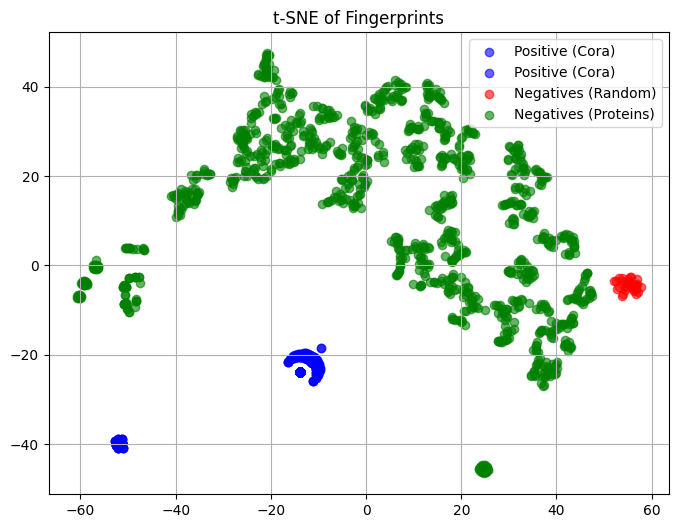

In [ ]:
import torch
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Load your original fingerprints
pos_fp = torch.load('/content/drive/MyDrive/gnnfingers/fingerprints/fps_Cora_SAGEMean.pt')            # (400, 64)
neg_fp_random = torch.load('/content/drive/MyDrive/gnnfingers/fingerprints/Cora_GCNMean_neg_random.pt')  # (30, 7)
neg_fp_proteins = torch.load('/content/drive/MyDrive/gnnfingers/fingerprints/neg_fp_proteins.pt')        # (1113, 2)

# Pad to 64 dimensions
def pad_tensor(t, target_dim=64):
    return F.pad(t, (0, target_dim - t.shape[1]), "constant", 0)

neg_fp_random_padded = pad_tensor(neg_fp_random, 64)
neg_fp_proteins_padded = pad_tensor(neg_fp_proteins, 64)

# Combine all
X_all = torch.cat([pos_fp, neg_fp_random_padded, neg_fp_proteins_padded], dim=0).numpy()
y_all = np.array([1]*len(pos_fp) + [0]*len(neg_fp_random_padded) + [0]*len(neg_fp_proteins_padded))

# Run t-SNE with low perplexity
tsne = TSNE(n_components=2, perplexity=20, n_iter=1000, init='random', learning_rate='auto', random_state=42)
X_tsne = tsne.fit_transform(X_all)

# Plot
plt.figure(figsize=(8,6))
plt.scatter(X_tsne[y_all == 1, 0], X_tsne[y_all == 1, 1], c='blue', label='Positive (Cora)', alpha=0.6)
plt.scatter(X_tsne[:len(pos_fp), 0], X_tsne[:len(pos_fp), 1], c='blue', label='Positive (Cora)', alpha=0.6)
plt.scatter(X_tsne[len(pos_fp):len(pos_fp)+len(neg_fp_random_padded), 0],
            X_tsne[len(pos_fp):len(pos_fp)+len(neg_fp_random_padded), 1],
            c='red', label='Negatives (Random)', alpha=0.6)
plt.scatter(X_tsne[-len(neg_fp_proteins_padded):, 0],
            X_tsne[-len(neg_fp_proteins_padded):, 1],
            c='green', label='Negatives (Proteins)', alpha=0.6)
plt.legend()
plt.title('t-SNE of Fingerprints')
plt.grid(True)
plt.show()


In [ ]:
import torch
from sklearn.metrics import roc_auc_score, confusion_matrix

# Simulate small dataset
torch.manual_seed(42)
pos_fp = torch.randn(10, 64)
neg_fp_random = torch.randn(5, 64)
neg_fp_proteins = torch.randn(5, 64)

# Concatenate
X = torch.cat([pos_fp, neg_fp_random, neg_fp_proteins], dim=0)
y = torch.cat([torch.ones(len(pos_fp)), torch.zeros(len(neg_fp_random) + len(neg_fp_proteins))])

# Mock classifier: dot product with random weights
weights = torch.randn(64)
logits = X @ weights
probs = torch.sigmoid(logits)

# AUROC
auroc = roc_auc_score(y.numpy(), probs.detach().numpy())

# Confusion matrix at 0.5 threshold
y_pred = (probs >= 0.5).long()
conf_mat = confusion_matrix(y.numpy(), y_pred.numpy())

print(" AUROC:", round(auroc, 4))
print(" Confusion Matrix:\n", conf_mat)


 AUROC: 0.52
 Confusion Matrix:
 [[6 4]
 [6 4]]
